### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

In [2]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9012457922980777620
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9959542138907620465
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import data

In [4]:
data = pd.read_csv("data/data.csv")

In [5]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,26.743154
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0,26.110083
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,27.539522
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,32.448371
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,7.887498


### insight

#### HYDGRP Distribution

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='As'>

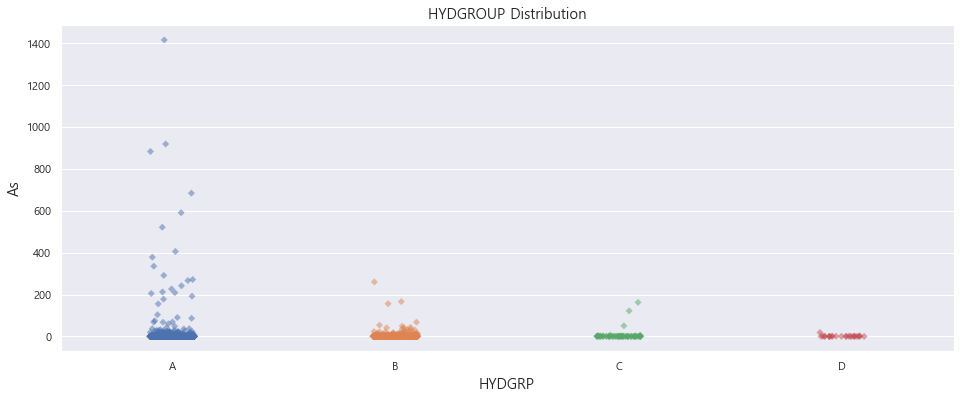

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('As Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'As', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='Cd'>

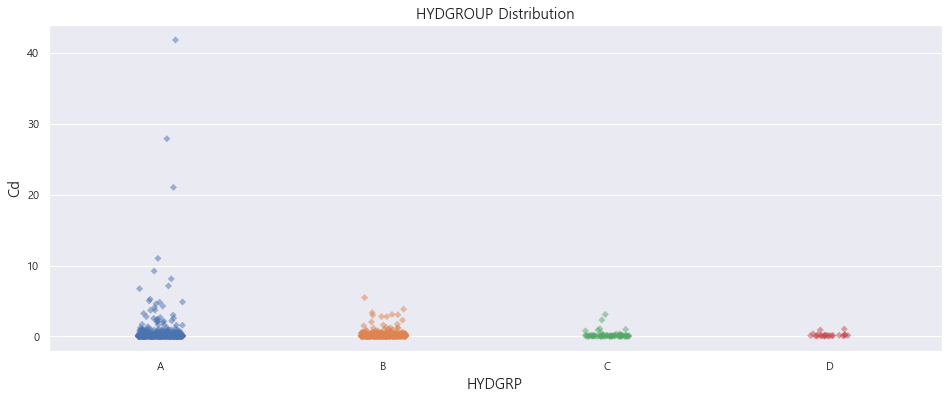

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('Cd Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'Cd', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='Ni'>

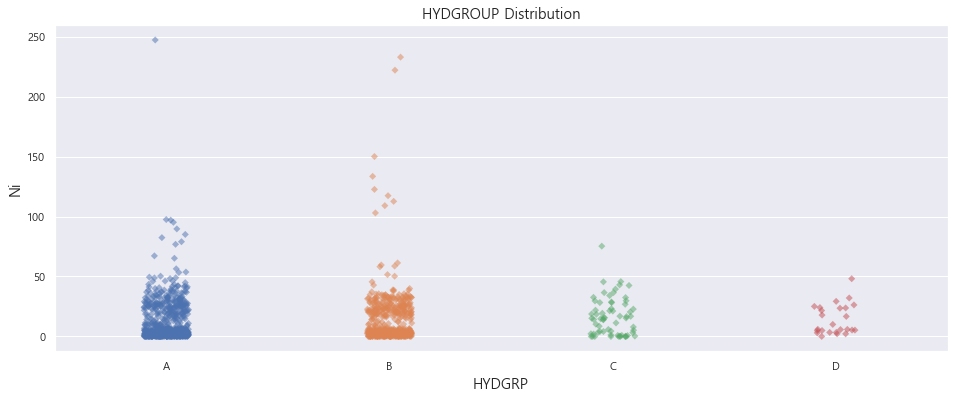

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('Ni Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'Ni', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

#### Curve Distribution

In [ ]:
def visual_curve(data, value):
    fig, ax = plt.subplots(figsize=(16, 6))

    ax.set_title('Curve Distribution', size='large')
    ax.set_xlabel('profile curve', size='large')
    ax.set_ylabel(value+' Concentration', size='large')

    plt.scatter(x = 'profile_curve', y = value, data = data, marker='D', alpha=.5)
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.set_title('Curve Distribution', size='large')
    ax.set_xlabel('planform curve', size='large')
    ax.set_ylabel(value+' Concentration', size='large')

    plt.scatter(x = 'planform_curve', y = value, data = data, marker='D', alpha=.5, c='red')
    plt.show()

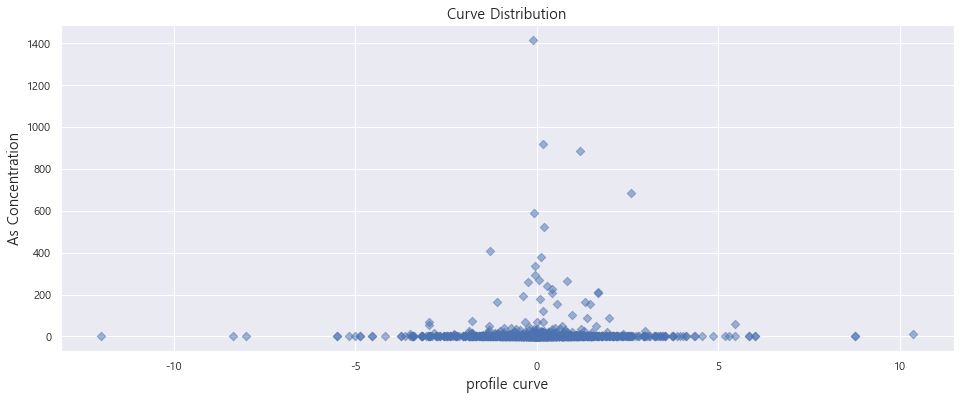

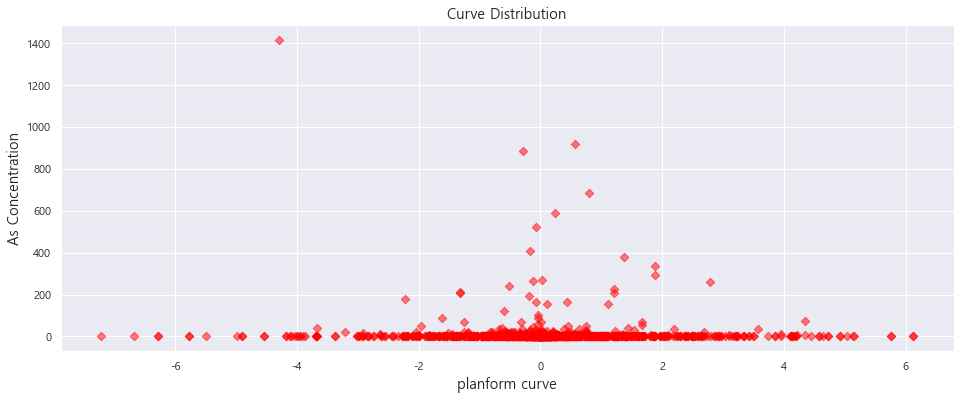

In [ ]:
visual_curve(data, 'As')

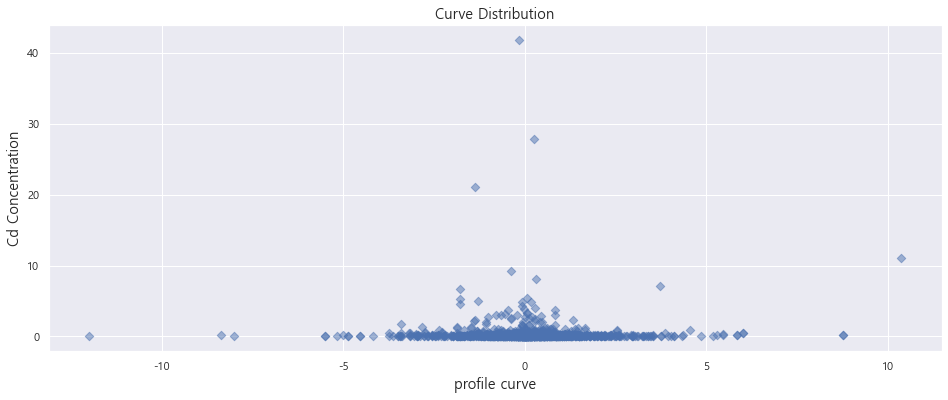

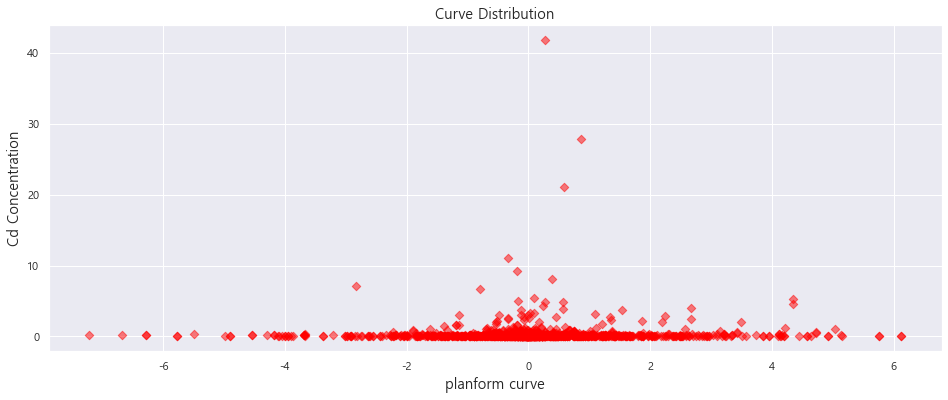

In [ ]:
visual_curve(data, 'Cd')

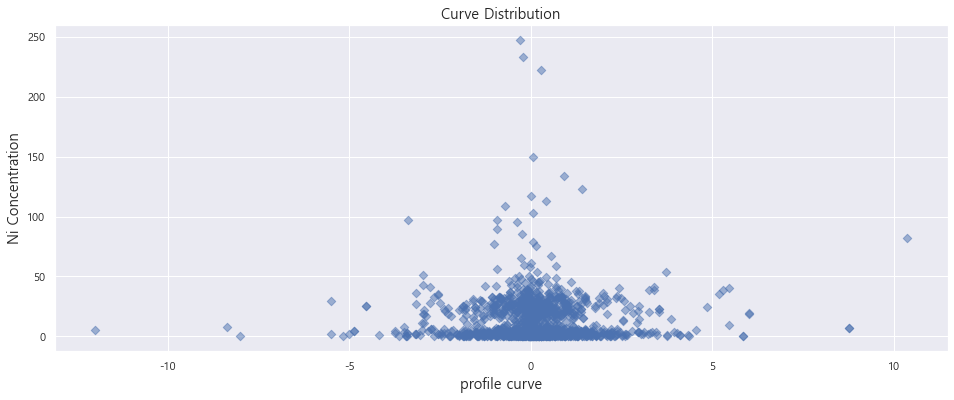

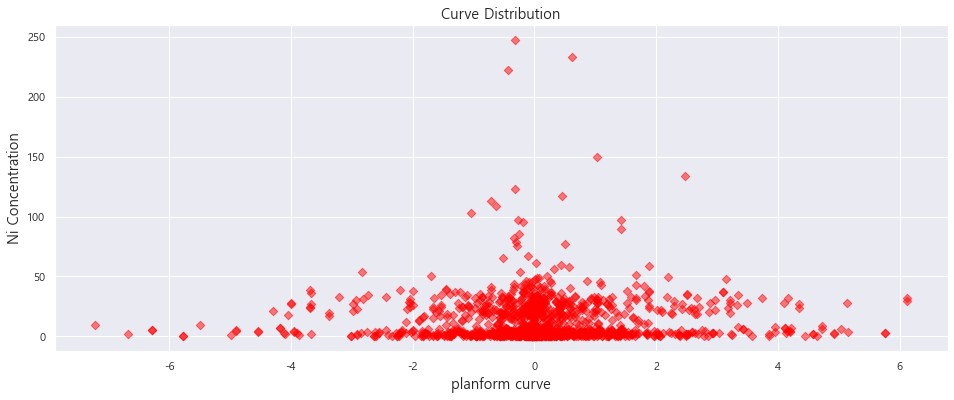

In [ ]:
visual_curve(data, 'Ni')

### Processing missing data & Drop unnecessary data

In [ ]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

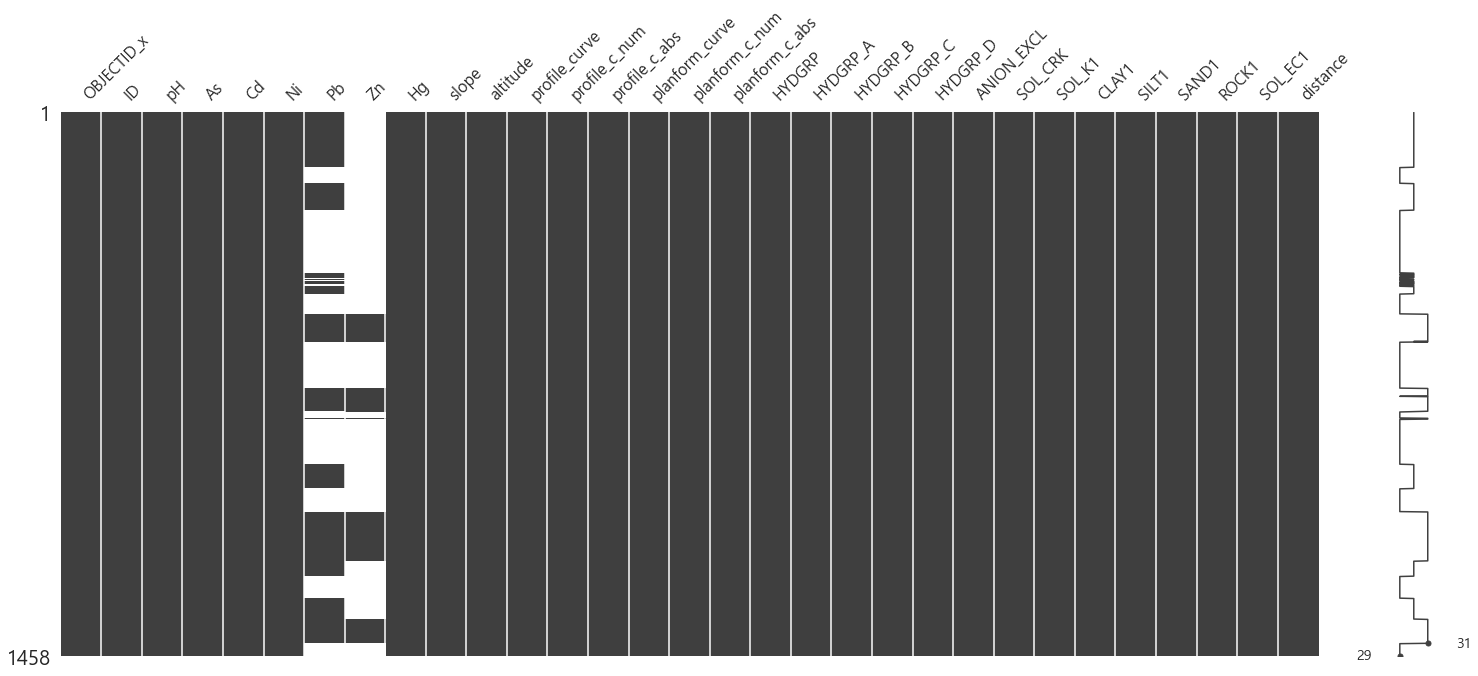

In [6]:
msno.matrix(data)

### YJ mine drop

In [7]:
yj_mine_data = data.loc[263:299,:]

In [8]:
yj_mine_data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
263,264,KW-YJ-PS-01,8.10,1.06,0.100,0.60,NaN,NaN,0.0,41.733299,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,13.175603
264,265,KW-YJ-PS-02,7.70,1.06,0.100,0.60,NaN,NaN,0.0,37.331100,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,12.951280
265,266,KW-YJ-PS-03,7.40,1.06,0.100,0.50,NaN,NaN,0.0,8.445270,...,0,0.5,0.5,12.03,17.0,46.0,37.0,14.0,0,12.036604
266,267,KW-YJ-S-04,5.65,0.25,0.060,3.17,NaN,NaN,0.0,11.050300,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,13.797559
267,268,KW-YJ-S-05,5.80,3.64,0.075,1.38,NaN,NaN,0.0,29.640400,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,13.786335


In [9]:
for i in range(263, 300):
    data = data.drop(index = i)

In [10]:
data = data.drop(['ID'], axis = 1)
yj_mine_data = yj_mine_data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
yj_mine_data = yj_mine_data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [11]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [12]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [13]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [14]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [15]:
# yj mine

As_yj_mine_data = yj_mine_data
Cd_yj_mine_data = yj_mine_data
Ni_yj_mine_data = yj_mine_data

As_yj_mine_data = As_yj_mine_data.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_yj_mine_data = Cd_yj_mine_data.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_yj_mine_data = Ni_yj_mine_data.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [16]:
As_yj_value = yj_mine_data['As']
Cd_yj_value = yj_mine_data['Cd']
Ni_yj_value = yj_mine_data['Ni']

### Check the value skewed

#### As

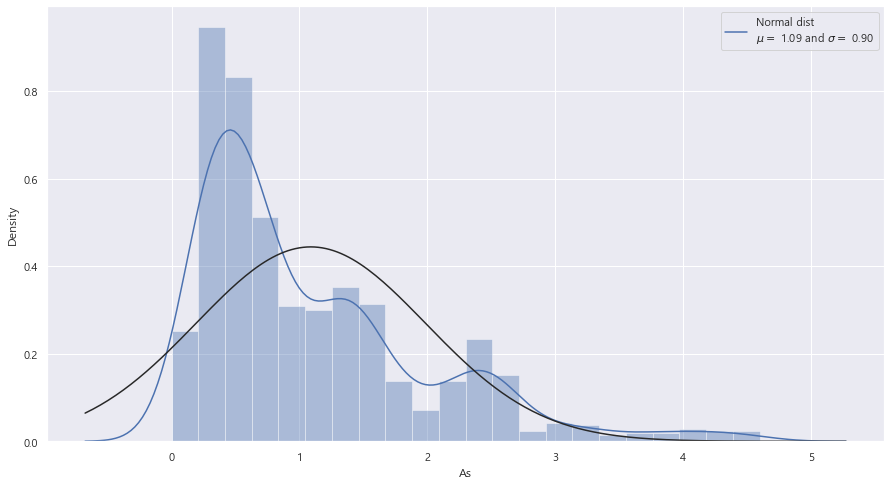

In [ ]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

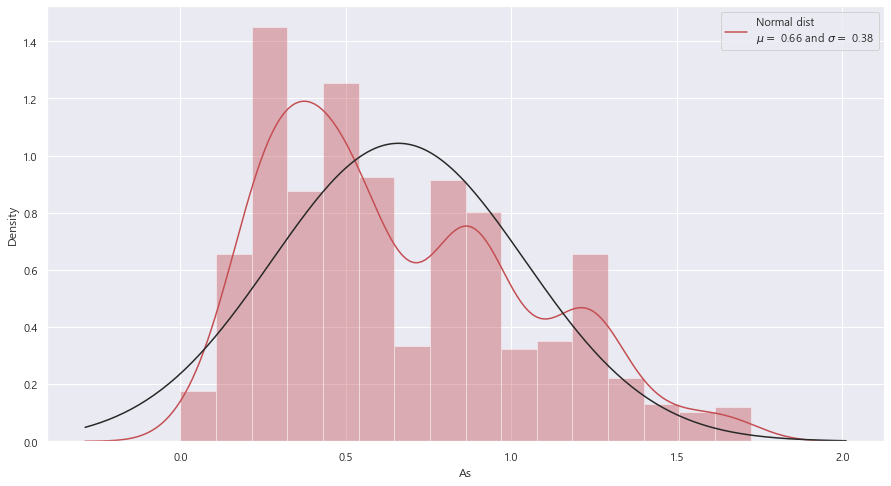

In [ ]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

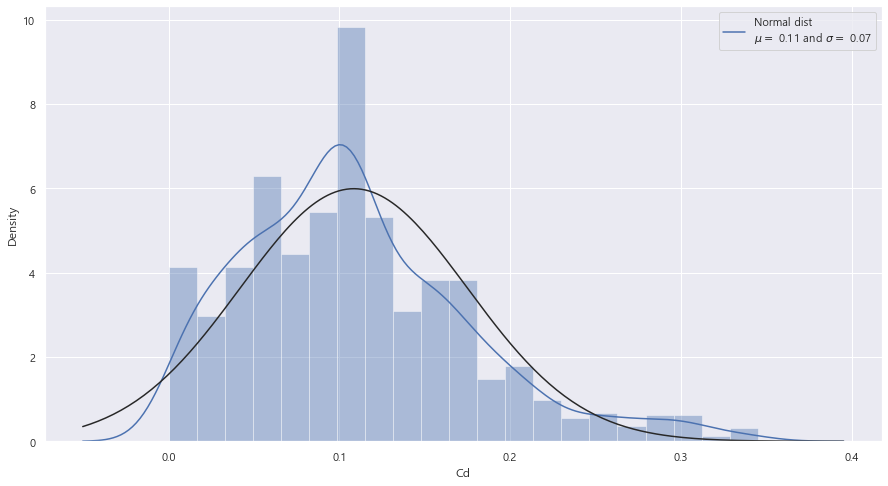

In [ ]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

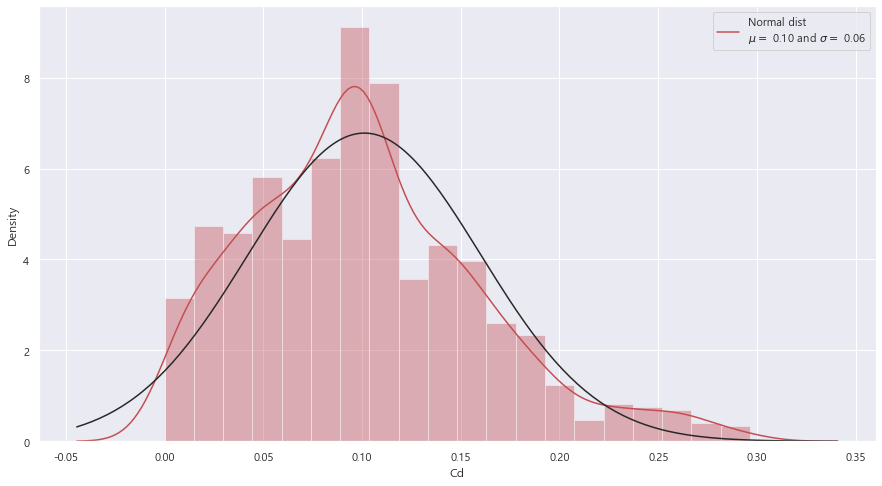

In [ ]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

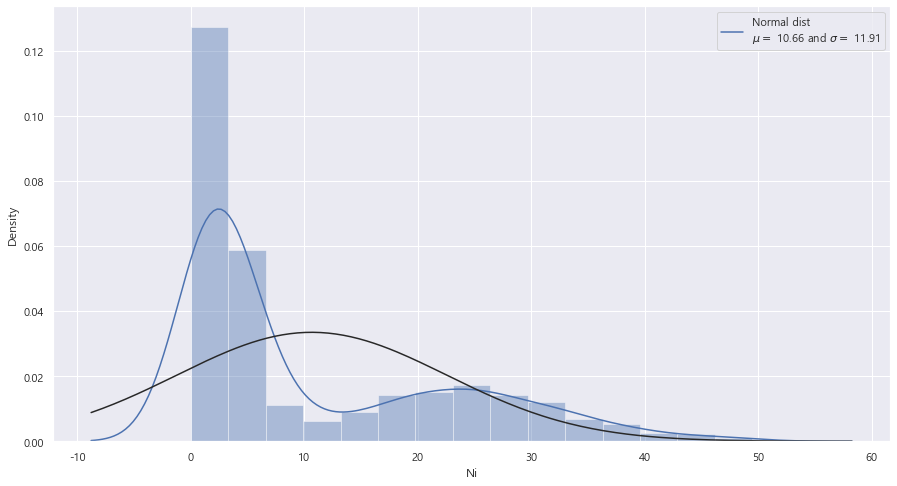

In [ ]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

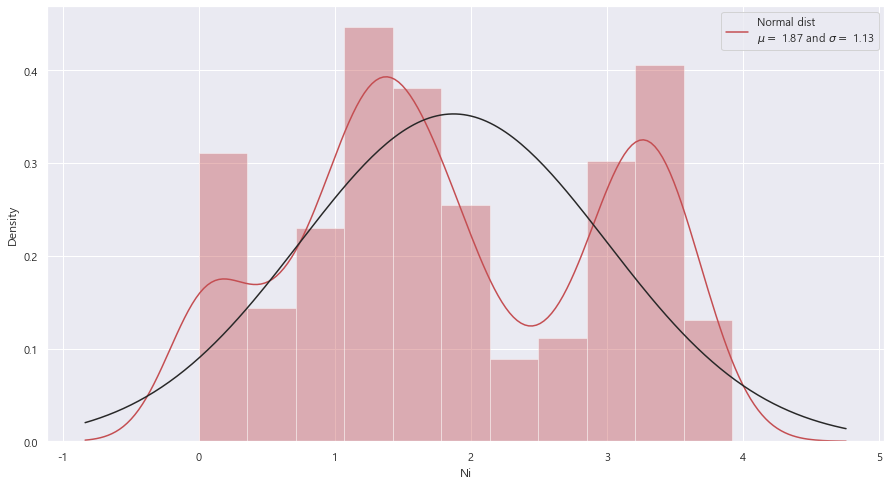

In [ ]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [17]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

In [18]:
As_test_index = As_test.index
Cd_test_index = Cd_test.index
Ni_test_index = Ni_test.index

#### Scaling

In [19]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [20]:
scaler = StandardScaler()

scaler.fit(As_X)
As_X = pd.DataFrame(scaler.transform(As_X), columns=As_X.columns)
As_test = pd.DataFrame(scaler.transform(As_test), columns=As_test.columns)
As_yj_mine_data = pd.DataFrame(scaler.transform(As_yj_mine_data), columns=As_yj_mine_data.columns)

scaler.fit(Cd_X)
Cd_X = pd.DataFrame(scaler.transform(Cd_X), columns=Cd_X.columns)
Cd_test = pd.DataFrame(scaler.transform(Cd_test), columns=Cd_test.columns)
Cd_yj_mine_data = pd.DataFrame(scaler.transform(Cd_yj_mine_data), columns=Cd_yj_mine_data.columns)

scaler.fit(Ni_X)
Ni_X = pd.DataFrame(scaler.transform(Ni_X), columns=Ni_X.columns)
Ni_test = pd.DataFrame(scaler.transform(Ni_test), columns=Ni_test.columns)
Ni_yj_mine_data = pd.DataFrame(scaler.transform(Ni_yj_mine_data), columns=Ni_yj_mine_data.columns)

#### 20-Fold Crossvalidation

In [21]:
kf = KFold(n_splits = 20, random_state = 605, shuffle = True)

#### def R2 calculating

In [22]:
def SST(data, pred):
    sst = 0
    
    for i in range(0, len(pred)):
        sst += ((data[i] - np.mean(data))**2)
        
    return sst

def SSE(data, pred):
    sse = 0
    
    for i in range(0, len(pred)):
        sse += ((pred[i] - np.mean(data))**2)
        
    return sse

def SSR(data, pred):
    ssr = 0
    
    for i in range(0, len(data)):
        ssr += ((data[i] - pred[i])**2)
    
    return ssr

In [23]:
def cal_train_r2(pred, data):
    test = pd.DataFrame(data.values, columns=['real_value'])
    test['value'] = pred
    
    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = sse + ssr
    
    test_r2 = sse/sst
    
    return test_r2

def cal_val_r2(pred, data):
    test = pd.DataFrame()
    test['real_value'] = data
    test['value'] = pred
    
    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = sse + ssr
    
    test_r2 = SSE(test['real_value'], test['value'])/SST(test['real_value'], test['value'])
        
    return test_r2

def cal_val_r2_2(pred, data):
    test = pd.DataFrame()
    test['real_value'] = data
    test['value'] = pred
    
    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = sse + ssr
    
    test_r2 = sse/sst
        
    return test_r2

#### 1) NGBRegressor

In [24]:
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

def ngb_model(test, mine, X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.1, verbose=False)
    
    ngb_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        ngb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
        
        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in ngb.predict(mine)]) / 20
        
        ngb_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {ngb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {ngb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

    return ngb_pred, mine_pred

def ngb_train_model(X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.1, verbose=False)

    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        ngb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in ngb.predict(tr_x)])
        
        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)
    
    print(f'Train {ngb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {ngb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [25]:
As_ngb_pred, As_ngb_mine_pred = ngb_model(As_test, As_yj_mine_data, As_X, As_y)

Validation NGBRegressor의 20fold 평균 RMSE는 0.24669386565400528
Validation NGBRegressor의 20fold 평균 R2는 0.7689968895872412


In [26]:
Cd_ngb_pred, Cd_ngb_mine_pred = ngb_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation NGBRegressor의 20fold 평균 RMSE는 0.01845238152592616
Validation NGBRegressor의 20fold 평균 R2는 0.7678260390484717


In [27]:
Ni_ngb_pred, Ni_ngb_mine_pred = ngb_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation NGBRegressor의 20fold 평균 RMSE는 2.1192126939873637
Validation NGBRegressor의 20fold 평균 R2는 0.8921033194435688


In [28]:
ngb_train_model(As_X, As_y)
ngb_train_model(Cd_X, Cd_y)
ngb_train_model(Ni_X, Ni_y)

Train NGBRegressor의 20fold 평균 RMSE는 0.20048608462624462
Train NGBRegressor의 20fold 평균 R2는 0.9403025999026349
Train NGBRegressor의 20fold 평균 RMSE는 0.014125095255054704
Train NGBRegressor의 20fold 평균 R2는 0.9474009936111921
Train NGBRegressor의 20fold 평균 RMSE는 1.9012583927180624
Train NGBRegressor의 20fold 평균 R2는 0.9683520770726419


#### 2) RandomForestRegressor

In [29]:
def rf_model(test, mine, X, y):
    rf = RandomForestRegressor(random_state = 605, n_estimators = 1000, max_depth = 30)
    
    rf_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        rf.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
        
        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in rf.predict(mine)]) / 20
        
        rf_pred += sub_pred
        mine_pred += sub_pred_2

    
    print(f'Validation {rf.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {rf.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')
    
    return rf_pred, mine_pred

def rf_train_model(X, y):
    rf = RandomForestRegressor(random_state = 605, n_estimators = 1000, max_depth = 30)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        rf.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in rf.predict(tr_x)])
        
        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)

    
    print(f'Train {rf.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {rf.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [30]:
As_rf_pred, As_rf_mine_pred = rf_model(As_test, As_yj_mine_data, As_X, As_y)

Validation RandomForestRegressor의 20fold 평균 RMSE는 0.8479016020775413
Validation RandomForestRegressor의 20fold 평균 R2는 0.23162196932927914


In [31]:
Cd_rf_pred, Cd_rf_mine_pred = rf_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation RandomForestRegressor의 20fold 평균 RMSE는 0.06136682511340532
Validation RandomForestRegressor의 20fold 평균 R2는 0.2913963240387528


In [32]:
Ni_rf_pred, Ni_rf_mine_pred = rf_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation RandomForestRegressor의 20fold 평균 RMSE는 6.936497093956243
Validation RandomForestRegressor의 20fold 평균 R2는 0.5453072053350652


In [33]:
rf_train_model(As_X, As_y)
rf_train_model(Cd_X, Cd_y)
rf_train_model(Ni_X, Ni_y)

Train RandomForestRegressor의 20fold 평균 RMSE는 0.35817019449058857
Train RandomForestRegressor의 20fold 평균 R2는 0.841035787495214
Train RandomForestRegressor의 20fold 평균 RMSE는 0.02300007700218315
Train RandomForestRegressor의 20fold 평균 R2는 0.8806108414191041
Train RandomForestRegressor의 20fold 평균 RMSE는 3.296450084064348
Train RandomForestRegressor의 20fold 평균 R2는 0.9233347529363435


#### 3) ExtraTreesRegressor

In [34]:
def etc_model(test, mine, X, y):
    etc = ExtraTreesRegressor(random_state = 605, n_estimators = 1000)
    
    etc_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        etc.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in etc.predict(mine)]) / 20

        etc_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {etc.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {etc.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

    return etc_pred, mine_pred

def etc_train_model(X, y):
    etc = ExtraTreesRegressor(random_state = 605, n_estimators = 1000)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        etc.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in etc.predict(tr_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)
    
    print(f'Train {etc.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {etc.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [35]:
As_etc_pred, As_etc_mine_pred = etc_model(As_test, As_yj_mine_data, As_X, As_y)

Validation ExtraTreesRegressor의 20fold 평균 RMSE는 0.8824839187155564
Validation ExtraTreesRegressor의 20fold 평균 R2는 0.3986019187511044


In [36]:
Cd_etc_pred, Cd_etc_mine_pred = etc_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation ExtraTreesRegressor의 20fold 평균 RMSE는 0.06377209825042267
Validation ExtraTreesRegressor의 20fold 평균 R2는 0.48577859079689584


In [37]:
Ni_etc_pred, Ni_etc_mine_pred = etc_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation ExtraTreesRegressor의 20fold 평균 RMSE는 6.699426087784748
Validation ExtraTreesRegressor의 20fold 평균 R2는 0.6762067361031323


In [38]:
etc_train_model(As_X, As_y)
etc_train_model(Cd_X, Cd_y)
etc_train_model(Ni_X, Ni_y)

Train ExtraTreesRegressor의 20fold 평균 RMSE는 0.02781569517611257
Train ExtraTreesRegressor의 20fold 평균 R2는 0.998935227985657
Train ExtraTreesRegressor의 20fold 평균 RMSE는 0.00010401871183325145
Train ExtraTreesRegressor의 20fold 평균 R2는 0.999997289527423
Train ExtraTreesRegressor의 20fold 평균 RMSE는 0.014844702754863711
Train ExtraTreesRegressor의 20fold 평균 R2는 0.9999982881615226


#### 4) GradientBoostingRegressor

In [39]:
def gb_model(test, mine, X, y):
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 1000, learning_rate = 0.1, max_depth = 30)
    
    gb_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2_2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in gb.predict(mine)]) / 20
        
        gb_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {gb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {gb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')
    
    return gb_pred, mine_pred

def gb_train_model(X, y):
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 1000, learning_rate = 0.1, max_depth = 30)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(tr_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)
    
    print(f'Train {gb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {gb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [40]:
As_gb_pred, As_gb_mine_pred = gb_model(As_test, As_yj_mine_data, As_X, As_y)

Validation GradientBoostingRegressor의 20fold 평균 RMSE는 1.1063115104415158
Validation GradientBoostingRegressor의 20fold 평균 R2는 0.3918369125076084


In [41]:
Cd_gb_pred, Cd_gb_mine_pred = gb_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation GradientBoostingRegressor의 20fold 평균 RMSE는 0.08126269611546673
Validation GradientBoostingRegressor의 20fold 평균 R2는 0.3855278129954597


In [42]:
Ni_gb_pred, Ni_gb_mine_pred = gb_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation GradientBoostingRegressor의 20fold 평균 RMSE는 8.482323335121379
Validation GradientBoostingRegressor의 20fold 평균 R2는 0.6632971529753793


In [43]:
gb_train_model(As_X, As_y)
gb_train_model(Cd_X, Cd_y)
gb_train_model(Ni_X, Ni_y)

Train GradientBoostingRegressor의 20fold 평균 RMSE는 0.027815695176109774
Train GradientBoostingRegressor의 20fold 평균 R2는 0.998935227985657
Train GradientBoostingRegressor의 20fold 평균 RMSE는 0.00010401871183308918
Train GradientBoostingRegressor의 20fold 평균 R2는 0.999997289527423
Train GradientBoostingRegressor의 20fold 평균 RMSE는 0.01484470275482418
Train GradientBoostingRegressor의 20fold 평균 R2는 0.9999982881615226


#### 5) CatBoostRegressor

In [44]:
def cb_model(test, mine, X, y):
    cb = CatBoostRegressor(random_state = 605, silent = True, depth = 5, learning_rate = 0.1)
    
    cb_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        cb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in cb.predict(mine)]) / 20
        
        cb_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {cb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {cb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')
    
    return cb_pred, mine_pred

def cb_train_model(X, y):
    cb = CatBoostRegressor(random_state = 605, silent = True, depth = 4, learning_rate = 0.1)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        cb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in cb.predict(tr_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)
    
    print(f'Train {cb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {cb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [45]:
As_cb_pred, As_cb_mine_pred = cb_model(As_test, As_yj_mine_data, As_X, As_y)

Validation CatBoostRegressor의 20fold 평균 RMSE는 0.8991688498022972
Validation CatBoostRegressor의 20fold 평균 R2는 0.37810544203971375


In [46]:
Cd_cb_pred, Cd_cb_mine_pred = cb_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation CatBoostRegressor의 20fold 평균 RMSE는 0.06341317681710293
Validation CatBoostRegressor의 20fold 평균 R2는 0.44675796777993426


In [47]:
Ni_cb_pred, Ni_cb_mine_pred = cb_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation CatBoostRegressor의 20fold 평균 RMSE는 7.05443785284641
Validation CatBoostRegressor의 20fold 평균 R2는 0.7318414707087254


In [48]:
cb_train_model(As_X, As_y)
cb_train_model(Cd_X, Cd_y)
cb_train_model(Ni_X, Ni_y)

Train CatBoostRegressor의 20fold 평균 RMSE는 0.333054673245553
Train CatBoostRegressor의 20fold 평균 R2는 0.8624661173794175
Train CatBoostRegressor의 20fold 평균 RMSE는 0.02084869756101035
Train CatBoostRegressor의 20fold 평균 R2는 0.9018871764455024
Train CatBoostRegressor의 20fold 평균 RMSE는 3.072636264500312
Train CatBoostRegressor의 20fold 평균 R2는 0.9333870564628068


#### 6) LGBMRegressor

In [49]:
def lgbm_model(test, mine, X, y):
    lgbm = LGBMRegressor(random_state = 605, max_depth = 4, 
                         n_estimators = 1000, num_leaves = 16, min_child_samples = 3, learning_rate = 0.1, num_iterations = 1000)
    
    lgbm_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        lgbm.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)

        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in lgbm.predict(mine)]) / 20

        lgbm_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {lgbm.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {lgbm.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')
    return lgbm_pred, mine_pred

def lgbm_train_model(X, y):
    lgbm = LGBMRegressor(random_state = 605, max_depth = 4, 
                         n_estimators = 1000, num_leaves = 64, min_child_samples = 3, learning_rate = 0.1, num_iterations = 1000)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        lgbm.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(tr_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)

        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)
    
    print(f'Train {lgbm.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {lgbm.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [50]:
As_lgbm_pred, As_lgbm_mine_pred = lgbm_model(As_test, As_yj_mine_data, As_X, As_y)

Validation LGBMRegressor의 20fold 평균 RMSE는 0.9272963712431037
Validation LGBMRegressor의 20fold 평균 R2는 0.4666581800114261


In [51]:
Cd_lgbm_pred, Cd_lgbm_mine_pred = lgbm_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation LGBMRegressor의 20fold 평균 RMSE는 0.06640804057764495
Validation LGBMRegressor의 20fold 평균 R2는 0.5629199364391647


In [52]:
Ni_lgbm_pred, Ni_lgbm_mine_pred = lgbm_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation LGBMRegressor의 20fold 평균 RMSE는 7.2871939702852035
Validation LGBMRegressor의 20fold 평균 R2는 0.7675576196795408


In [53]:
lgbm_train_model(As_X, As_y)
lgbm_train_model(Cd_X, Cd_y)
lgbm_train_model(Ni_X, Ni_y)

Train LGBMRegressor의 20fold 평균 RMSE는 0.10210499585066295
Train LGBMRegressor의 20fold 평균 R2는 0.9870575513779727
Train LGBMRegressor의 20fold 평균 RMSE는 0.005566427817901518
Train LGBMRegressor의 20fold 평균 R2는 0.9929979340560479
Train LGBMRegressor의 20fold 평균 RMSE는 0.7461142841274881
Train LGBMRegressor의 20fold 평균 R2는 0.9960597757456137


#### 7) XGBRegressor

In [54]:
def xgb_model(test, mine, X, y):
    xgb = XGBRegressor(random_state = 605, max_depth = 30, learning_rate = 0.1, 
                       eval_metric = 'rmse', verbosity = 0)
    
    xgb_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        xgb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in xgb.predict(mine)]) / 20

        xgb_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {xgb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {xgb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

    return xgb_pred, mine_pred

def xgb_train_model(X, y):
    xgb = XGBRegressor(random_state = 605, max_depth = 30, learning_rate = 0.1, 
                       eval_metric = 'rmse', verbosity = 0)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        xgb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in xgb.predict(tr_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = r2_score(np.expm1(tr_y), np.array(pred))
        r2_list.append(r2)
        
    print(f'Train {xgb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {xgb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [55]:
As_xgb_pred, As_xgb_mine_pred = xgb_model(As_test, As_yj_mine_data, As_X, As_y)

Validation XGBRegressor의 20fold 평균 RMSE는 0.9112810118246628
Validation XGBRegressor의 20fold 평균 R2는 0.48872202325826786


In [56]:
Cd_xgb_pred, Cd_xgb_mine_pred = xgb_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation XGBRegressor의 20fold 평균 RMSE는 0.06522684631564095
Validation XGBRegressor의 20fold 평균 R2는 0.5101848360709174


In [57]:
Ni_xgb_pred, Ni_xgb_mine_pred = xgb_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation XGBRegressor의 20fold 평균 RMSE는 6.800890467227963
Validation XGBRegressor의 20fold 평균 R2는 0.7716329879520227


In [58]:
xgb_train_model(As_X, As_y)
xgb_train_model(Cd_X, Cd_y)
xgb_train_model(Ni_X, Ni_y)

Train XGBRegressor의 20fold 평균 RMSE는 0.028525718936986307
Train XGBRegressor의 20fold 평균 R2는 0.998911583654324
Train XGBRegressor의 20fold 평균 RMSE는 0.000908224085392579
Train XGBRegressor의 20fold 평균 R2는 0.9998136739850262
Train XGBRegressor의 20fold 평균 RMSE는 0.06816401251921539
Train XGBRegressor의 20fold 평균 R2는 0.9999671632199412


###  Evaluate Models

In [59]:
# test
#As
ngb_As_test = pd.DataFrame()
rf_As_test = pd.DataFrame()
etc_As_test = pd.DataFrame()
gb_As_test = pd.DataFrame()
cb_As_test = pd.DataFrame()
lgbm_As_test = pd.DataFrame()
xgb_As_test = pd.DataFrame()

#Cd
ngb_Cd_test = pd.DataFrame()
rf_Cd_test = pd.DataFrame()
etc_Cd_test = pd.DataFrame()
gb_Cd_test = pd.DataFrame()
cb_Cd_test = pd.DataFrame()
lgbm_Cd_test = pd.DataFrame()
xgb_Cd_test = pd.DataFrame()

#Ni
ngb_Ni_test = pd.DataFrame()
rf_Ni_test = pd.DataFrame()
etc_Ni_test = pd.DataFrame()
gb_Ni_test = pd.DataFrame()
cb_Ni_test = pd.DataFrame()
lgbm_Ni_test = pd.DataFrame()
xgb_Ni_test = pd.DataFrame()


In [60]:
# mine
#As
mine_ngb_As_test = pd.DataFrame()
mine_rf_As_test = pd.DataFrame()
mine_etc_As_test = pd.DataFrame()
mine_gb_As_test = pd.DataFrame()
mine_cb_As_test = pd.DataFrame()
mine_lgbm_As_test = pd.DataFrame()
mine_xgb_As_test = pd.DataFrame()

#Cd
mine_ngb_Cd_test = pd.DataFrame()
mine_rf_Cd_test = pd.DataFrame()
mine_etc_Cd_test = pd.DataFrame()
mine_gb_Cd_test = pd.DataFrame()
mine_cb_Cd_test = pd.DataFrame()
mine_lgbm_Cd_test = pd.DataFrame()
mine_xgb_Cd_test = pd.DataFrame()

#Ni
mine_ngb_Ni_test = pd.DataFrame()
mine_rf_Ni_test = pd.DataFrame()
mine_etc_Ni_test = pd.DataFrame()
mine_gb_Ni_test = pd.DataFrame()
mine_cb_Ni_test = pd.DataFrame()
mine_lgbm_Ni_test = pd.DataFrame()
mine_xgb_Ni_test = pd.DataFrame()

In [61]:
# test
ngb_As_test['As_value'] = As_ngb_pred
ngb_Cd_test['Cd_value'] = Cd_ngb_pred
ngb_Ni_test['Ni_value'] = Ni_ngb_pred

rf_As_test['As_value'] = As_rf_pred
rf_Cd_test['Cd_value'] = Cd_rf_pred
rf_Ni_test['Ni_value'] = Ni_rf_pred

etc_As_test['As_value'] = As_etc_pred
etc_Cd_test['Cd_value'] = Cd_etc_pred
etc_Ni_test['Ni_value'] = Ni_etc_pred

gb_As_test['As_value'] = As_gb_pred
gb_Cd_test['Cd_value'] = Cd_gb_pred
gb_Ni_test['Ni_value'] = Ni_gb_pred

cb_As_test['As_value'] = As_cb_pred
cb_Cd_test['Cd_value'] = Cd_cb_pred
cb_Ni_test['Ni_value'] = Ni_cb_pred

lgbm_As_test['As_value'] = As_lgbm_pred
lgbm_Cd_test['Cd_value'] = Cd_lgbm_pred
lgbm_Ni_test['Ni_value'] = Ni_lgbm_pred

xgb_As_test['As_value'] = As_xgb_pred
xgb_Cd_test['Cd_value'] = Cd_xgb_pred
xgb_Ni_test['Ni_value'] = Ni_xgb_pred

In [62]:
# mine
mine_ngb_As_test['As_value'] = As_ngb_mine_pred
mine_ngb_Cd_test['Cd_value'] = Cd_ngb_mine_pred
mine_ngb_Ni_test['Ni_value'] = Ni_ngb_mine_pred

mine_rf_As_test['As_value'] = As_rf_mine_pred
mine_rf_Cd_test['Cd_value'] = Cd_rf_mine_pred
mine_rf_Ni_test['Ni_value'] = Ni_rf_mine_pred

mine_etc_As_test['As_value'] = As_etc_mine_pred
mine_etc_Cd_test['Cd_value'] = Cd_etc_mine_pred
mine_etc_Ni_test['Ni_value'] = Ni_etc_mine_pred

mine_gb_As_test['As_value'] = As_gb_mine_pred
mine_gb_Cd_test['Cd_value'] = Cd_gb_mine_pred
mine_gb_Ni_test['Ni_value'] = Ni_gb_mine_pred

mine_cb_As_test['As_value'] = As_cb_mine_pred
mine_cb_Cd_test['Cd_value'] = Cd_cb_mine_pred
mine_cb_Ni_test['Ni_value'] = Ni_cb_mine_pred

mine_lgbm_As_test['As_value'] = As_lgbm_mine_pred
mine_lgbm_Cd_test['Cd_value'] = Cd_lgbm_mine_pred
mine_lgbm_Ni_test['Ni_value'] = Ni_lgbm_mine_pred

mine_xgb_As_test['As_value'] = As_xgb_mine_pred
mine_xgb_Cd_test['Cd_value'] = Cd_xgb_mine_pred
mine_xgb_Ni_test['Ni_value'] = Ni_xgb_mine_pred

#### def quantile scailing

In [63]:
def data_scailing(test, value):
    q1 = test[value].quantile(0.004)
    q2 = test[value].quantile(0.99)
    
    test[value] = test[value].apply(lambda x: x if x > q1 else x * 0.9)
    test[value] = test[value].apply(lambda x: x if x < q2 else x * 1.1)
    
    return test

In [64]:
# test
# As
ngb_As_test = data_scailing(ngb_As_test, 'As_value')
rf_As_test = data_scailing(rf_As_test, 'As_value')
etc_As_test = data_scailing(etc_As_test, 'As_value')
gb_As_test = data_scailing(gb_As_test, 'As_value')
cb_As_test = data_scailing(cb_As_test, 'As_value')
lgbm_As_test = data_scailing(lgbm_As_test, 'As_value')
xgb_As_test = data_scailing(xgb_As_test, 'As_value')

# Cd
ngb_Cd_test = data_scailing(ngb_Cd_test, 'Cd_value')
rf_Cd_test = data_scailing(rf_Cd_test, 'Cd_value')
etc_Cd_test = data_scailing(etc_Cd_test, 'Cd_value')
gb_Cd_test = data_scailing(gb_Cd_test, 'Cd_value')
cb_Cd_test = data_scailing(cb_Cd_test, 'Cd_value')
lgbm_Cd_test = data_scailing(lgbm_Cd_test, 'Cd_value')
xgb_Cd_test = data_scailing(xgb_Cd_test, 'Cd_value')

# Ni
ngb_Ni_test = data_scailing(ngb_Ni_test, 'Ni_value')
rf_Ni_test = data_scailing(rf_Ni_test, 'Ni_value')
etc_Ni_test = data_scailing(etc_Ni_test, 'Ni_value')
gb_Ni_test = data_scailing(gb_Ni_test, 'Ni_value')
cb_Ni_test = data_scailing(cb_Ni_test, 'Ni_value')
lgbm_Ni_test = data_scailing(lgbm_Ni_test, 'Ni_value')
xgb_Ni_test = data_scailing(xgb_Ni_test, 'Ni_value')

In [65]:
# mine
# As
mine_ngb_As_test = data_scailing(mine_ngb_As_test, 'As_value')
mine_rf_As_test = data_scailing(mine_rf_As_test, 'As_value')
mine_etc_As_test = data_scailing(mine_etc_As_test, 'As_value')
mine_gb_As_test = data_scailing(mine_gb_As_test, 'As_value')
mine_cb_As_test = data_scailing(mine_cb_As_test, 'As_value')
mine_lgbm_As_test = data_scailing(mine_lgbm_As_test, 'As_value')
mine_xgb_As_test = data_scailing(mine_xgb_As_test, 'As_value')

# Cd
mine_ngb_Cd_test = data_scailing(mine_ngb_Cd_test, 'Cd_value')
mine_rf_Cd_test = data_scailing(mine_rf_Cd_test, 'Cd_value')
mine_etc_Cd_test = data_scailing(mine_etc_Cd_test, 'Cd_value')
mine_gb_Cd_test = data_scailing(mine_gb_Cd_test, 'Cd_value')
mine_cb_Cd_test = data_scailing(mine_cb_Cd_test, 'Cd_value')
mine_lgbm_Cd_test = data_scailing(mine_lgbm_Cd_test, 'Cd_value')
mine_xgb_Cd_test = data_scailing(mine_xgb_Cd_test, 'Cd_value')

# Ni
mine_ngb_Ni_test = data_scailing(mine_ngb_Ni_test, 'Ni_value')
mine_rf_Ni_test = data_scailing(mine_rf_Ni_test, 'Ni_value')
mine_etc_Ni_test = data_scailing(mine_etc_Ni_test, 'Ni_value')
mine_gb_Ni_test = data_scailing(mine_gb_Ni_test, 'Ni_value')
mine_cb_Ni_test = data_scailing(mine_cb_Ni_test, 'Ni_value')
mine_lgbm_Ni_test = data_scailing(mine_lgbm_Ni_test, 'Ni_value')
mine_xgb_Ni_test = data_scailing(mine_xgb_Ni_test, 'Ni_value')

In [66]:
# test
ngb_As_test['index'] = As_test_index
rf_As_test['index'] = As_test_index
etc_As_test['index'] = As_test_index
gb_As_test['index'] = As_test_index
cb_As_test['index'] = As_test_index
lgbm_As_test['index'] = As_test_index
xgb_As_test['index'] = As_test_index

ngb_Cd_test['index'] = Cd_test_index
rf_Cd_test['index'] = Cd_test_index
etc_Cd_test['index'] = Cd_test_index
gb_Cd_test['index'] = Cd_test_index
cb_Cd_test['index'] = Cd_test_index
lgbm_Cd_test['index'] = Cd_test_index
xgb_Cd_test['index'] = Cd_test_index

ngb_Ni_test['index'] = Ni_test_index
rf_Ni_test['index'] = Ni_test_index
etc_Ni_test['index'] = Ni_test_index
gb_Ni_test['index'] = Ni_test_index
cb_Ni_test['index'] = Ni_test_index
lgbm_Ni_test['index'] = Ni_test_index
xgb_Ni_test['index'] = Ni_test_index

In [67]:
for index in ngb_As_test['index']:
    ngb_As_test.loc[ngb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    rf_As_test.loc[rf_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    etc_As_test.loc[etc_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    gb_As_test.loc[gb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    cb_As_test.loc[cb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    lgbm_As_test.loc[lgbm_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    xgb_As_test.loc[xgb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']

for index in ngb_Cd_test['index']:
    ngb_Cd_test.loc[ngb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    rf_Cd_test.loc[rf_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    etc_Cd_test.loc[etc_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    gb_Cd_test.loc[gb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    cb_Cd_test.loc[cb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    lgbm_Cd_test.loc[lgbm_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    xgb_Cd_test.loc[xgb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    
for index in ngb_Ni_test['index']:
    ngb_Ni_test.loc[ngb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    rf_Ni_test.loc[rf_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    etc_Ni_test.loc[etc_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    gb_Ni_test.loc[gb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    cb_Ni_test.loc[cb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    lgbm_Ni_test.loc[lgbm_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    xgb_Ni_test.loc[xgb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [68]:
# mine
# As
mine_ngb_As_test['As_real_value'] = As_yj_value.values
mine_rf_As_test['As_real_value'] = As_yj_value.values
mine_etc_As_test['As_real_value'] = As_yj_value.values
mine_gb_As_test['As_real_value'] = As_yj_value.values
mine_cb_As_test['As_real_value'] = As_yj_value.values
mine_lgbm_As_test['As_real_value'] = As_yj_value.values
mine_xgb_As_test['As_real_value'] = As_yj_value.values

# Cd
mine_ngb_Cd_test['Cd_real_value'] = Cd_yj_value.values
mine_rf_Cd_test['Cd_real_value'] = Cd_yj_value.values
mine_etc_Cd_test['Cd_real_value'] = Cd_yj_value.values
mine_gb_Cd_test['Cd_real_value'] = Cd_yj_value.values
mine_cb_Cd_test['Cd_real_value'] = Cd_yj_value.values
mine_lgbm_Cd_test['Cd_real_value'] = Cd_yj_value.values
mine_xgb_Cd_test['Cd_real_value'] = Cd_yj_value.values

# Ni
mine_ngb_Ni_test['Ni_real_value'] = Ni_yj_value.values
mine_rf_Ni_test['Ni_real_value'] = Ni_yj_value.values
mine_etc_Ni_test['Ni_real_value'] = Ni_yj_value.values
mine_gb_Ni_test['Ni_real_value'] = Ni_yj_value.values
mine_cb_Ni_test['Ni_real_value'] = Ni_yj_value.values
mine_lgbm_Ni_test['Ni_real_value'] = Ni_yj_value.values
mine_xgb_Ni_test['Ni_real_value'] = Ni_yj_value.values

#### R2 scoring & RMSE

In [69]:
def cal_r2_score(list, value, pred_value):
    r2_list = []
    model_list = ['NGBR','RandomForest','ExtraTrees','GradientBoost','CatBoost','LightGBM','XGBR']
    index = 0
    
    for item in list:
        r2_list.append(SSE(item[value], item[pred_value])/SST(item[value], item[pred_value]))
    
    for item in r2_list:
        print(model_list[index]+' '+pred_value+' R2 score : '+str(item))
        index += 1

In [70]:
def cal_rmse(list, value, pred_value):
    rmse_list = []
    index = 0
    model_list = ['NGBR','RandomForest','ExtraTrees','GradientBoost','CatBoost','LightGBM','XGBR']
    
    for item in list:
        rmse_list.append(np.sqrt(mean_squared_error(item[value], item[pred_value])))
        
    for item in rmse_list:
        print(model_list[index]+' '+pred_value+' RMSE : '+str(item))
        index += 1

In [71]:
# test
r2_As_list = [ngb_As_test, rf_As_test, etc_As_test, gb_As_test, cb_As_test, lgbm_As_test, xgb_As_test]
r2_Cd_list = [ngb_Cd_test, rf_Cd_test, etc_Cd_test, gb_Cd_test, cb_Cd_test, lgbm_Cd_test, xgb_Cd_test]
r2_Ni_list = [ngb_Ni_test, rf_Ni_test, etc_Ni_test, gb_Ni_test, cb_Ni_test, lgbm_Ni_test, xgb_Ni_test]

# mine
r2_mine_As_list = [mine_ngb_As_test, mine_rf_As_test, mine_etc_As_test, mine_gb_As_test, mine_cb_As_test, mine_lgbm_As_test, mine_xgb_As_test]
r2_mine_Cd_list = [mine_ngb_Cd_test, mine_rf_Cd_test, mine_etc_Cd_test, mine_gb_Cd_test, mine_cb_Cd_test, mine_lgbm_Cd_test, mine_xgb_Cd_test]
r2_mine_Ni_list = [mine_ngb_Ni_test, mine_rf_Ni_test, mine_etc_Ni_test, mine_gb_Ni_test, mine_cb_Ni_test, mine_lgbm_Ni_test, mine_xgb_Ni_test]

#### test

In [72]:
cal_r2_score(r2_As_list, 'As_real_value', 'As_value')

NGBR As_value R2 score : 0.6007473191725443
RandomForest As_value R2 score : 0.25309737494894335
ExtraTrees As_value R2 score : 0.49231518831063414
GradientBoost As_value R2 score : 0.5831003751978113
CatBoost As_value R2 score : 0.42067784811087766
LightGBM As_value R2 score : 0.5424933245477346
XGBR As_value R2 score : 0.47362499775931216


In [73]:
cal_rmse(r2_As_list, 'As_real_value', 'As_value')

NGBR As_value RMSE : 0.8948967792967318
RandomForest As_value RMSE : 0.7713106890868544
ExtraTrees As_value RMSE : 0.8636096670640898
GradientBoost As_value RMSE : 0.9013833477128613
CatBoost As_value RMSE : 0.8374200249790664
LightGBM As_value RMSE : 0.8668133726580004
XGBR As_value RMSE : 0.8464661210498461


In [74]:
cal_r2_score(r2_Cd_list, 'Cd_real_value', 'Cd_value')

NGBR Cd_value R2 score : 0.4614117737376217
RandomForest Cd_value R2 score : 0.24428514009118238
ExtraTrees Cd_value R2 score : 0.4304261209289054
GradientBoost Cd_value R2 score : 0.5479404994794604
CatBoost Cd_value R2 score : 0.3514737489970821
LightGBM Cd_value R2 score : 0.4387682795663528
XGBR Cd_value R2 score : 0.39127373754886074


In [75]:
cal_rmse(r2_Cd_list, 'Cd_real_value', 'Cd_value')

NGBR Cd_value RMSE : 0.0671727911888456
RandomForest Cd_value RMSE : 0.06129654621101541
ExtraTrees Cd_value RMSE : 0.06620628022415417
GradientBoost Cd_value RMSE : 0.06688303408904547
CatBoost Cd_value RMSE : 0.06610361058129197
LightGBM Cd_value RMSE : 0.06614864391647753
XGBR Cd_value RMSE : 0.06254506639799852


In [76]:
cal_r2_score(r2_Ni_list, 'Ni_real_value', 'Ni_value')

NGBR Ni_value R2 score : 0.6365326281143688
RandomForest Ni_value R2 score : 0.46401828012636703
ExtraTrees Ni_value R2 score : 0.5525433411655467
GradientBoost Ni_value R2 score : 0.7096648291828188
CatBoost Ni_value R2 score : 0.5544161552709497
LightGBM Ni_value R2 score : 0.6157033014722751
XGBR Ni_value R2 score : 0.6169272627446711


In [77]:
cal_rmse(r2_Ni_list, 'Ni_real_value', 'Ni_value')

NGBR Ni_value RMSE : 7.31494685347733
RandomForest Ni_value RMSE : 7.112816908506841
ExtraTrees Ni_value RMSE : 6.100280218922056
GradientBoost Ni_value RMSE : 7.285324375845889
CatBoost Ni_value RMSE : 7.0202022889677185
LightGBM Ni_value RMSE : 7.1713897577983445
XGBR Ni_value RMSE : 6.836542475818235


### Visualization

#### test

In [143]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,14)},
        style='darkgrid',
       )

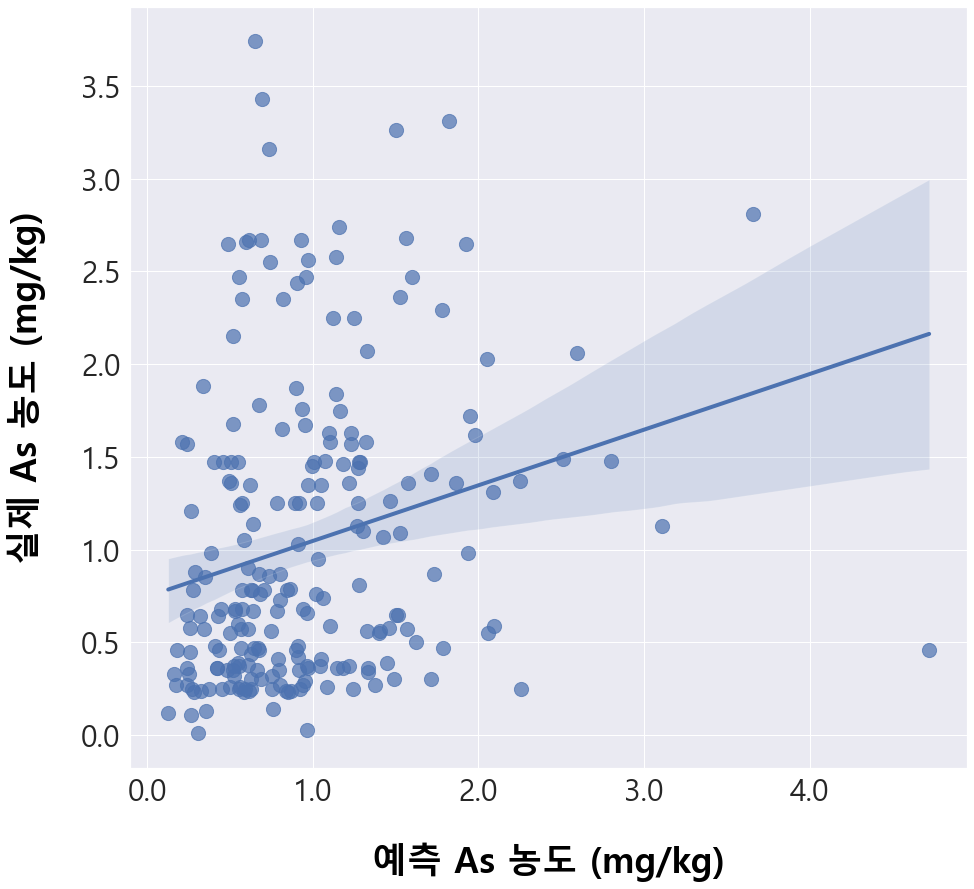

In [148]:
#plt.title('NGBregressor를 이용하여 예측한 As의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
#plt.scatter(ngb_As_test['As_value'], ngb_As_test['As_real_value'], marker='D', alpha=0.5)
plt.xticks(fontsize = 30)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(fontsize = 30)
sns.regplot(ngb_As_test['As_value'], ngb_As_test['As_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

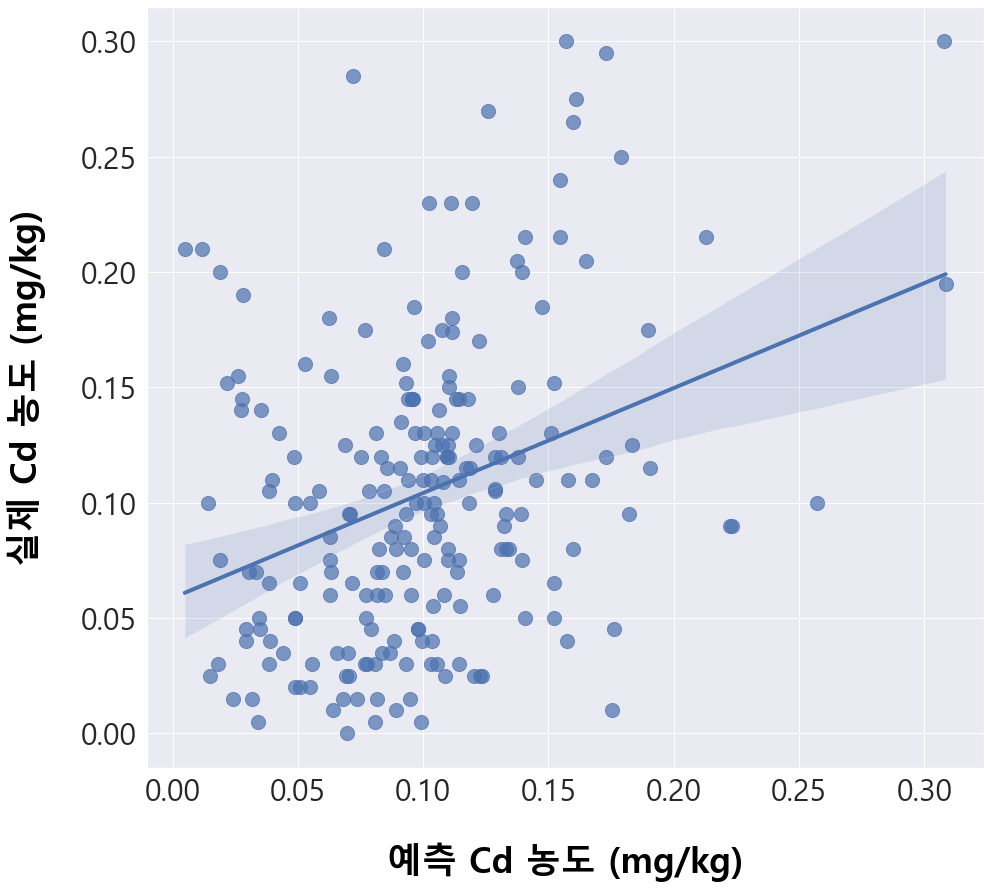

In [150]:
#plt.title('GradientBoostRegressor를 이용하여 예측한 Cd의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
#plt.scatter(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'], marker='D', alpha=0.5)
plt.xticks(fontsize = 30)
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(fontsize = 30)
sns.regplot(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

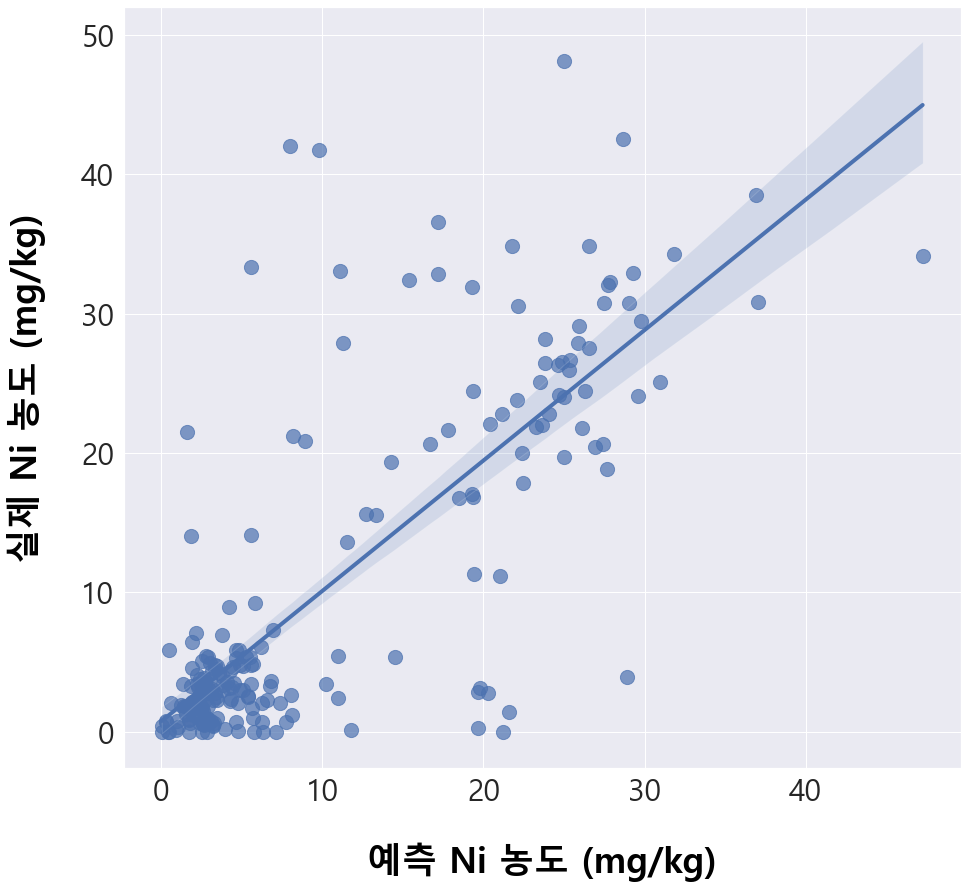

In [151]:
#plt.title('GradientBoostRegressor를 이용하여 예측한 Ni의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
#plt.scatter(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'], marker='D', alpha=0.5)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
sns.regplot(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

---

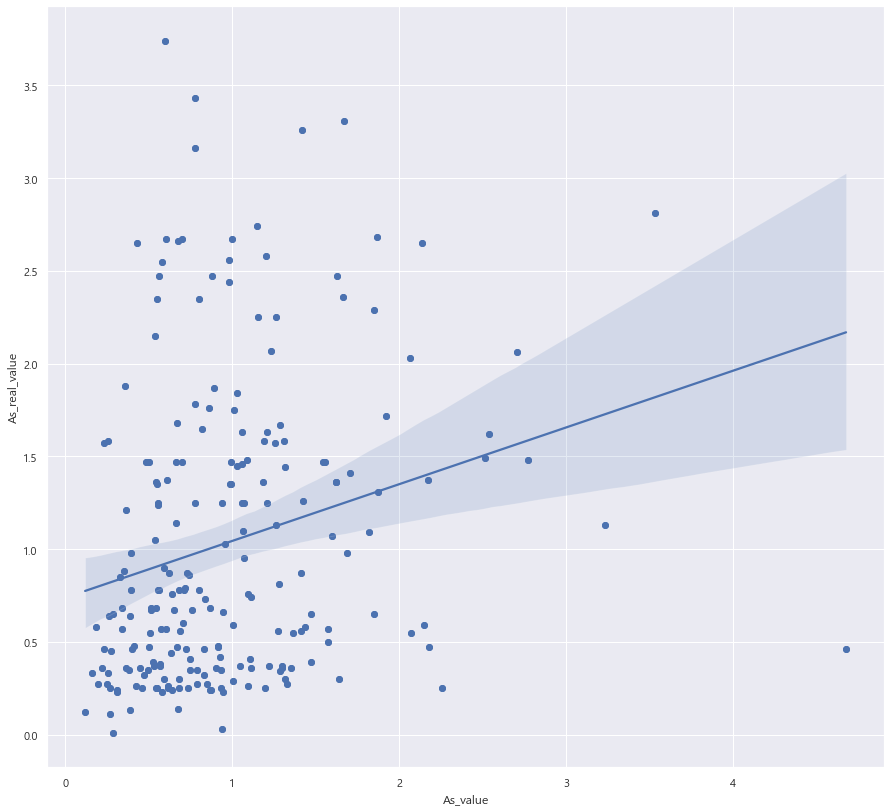

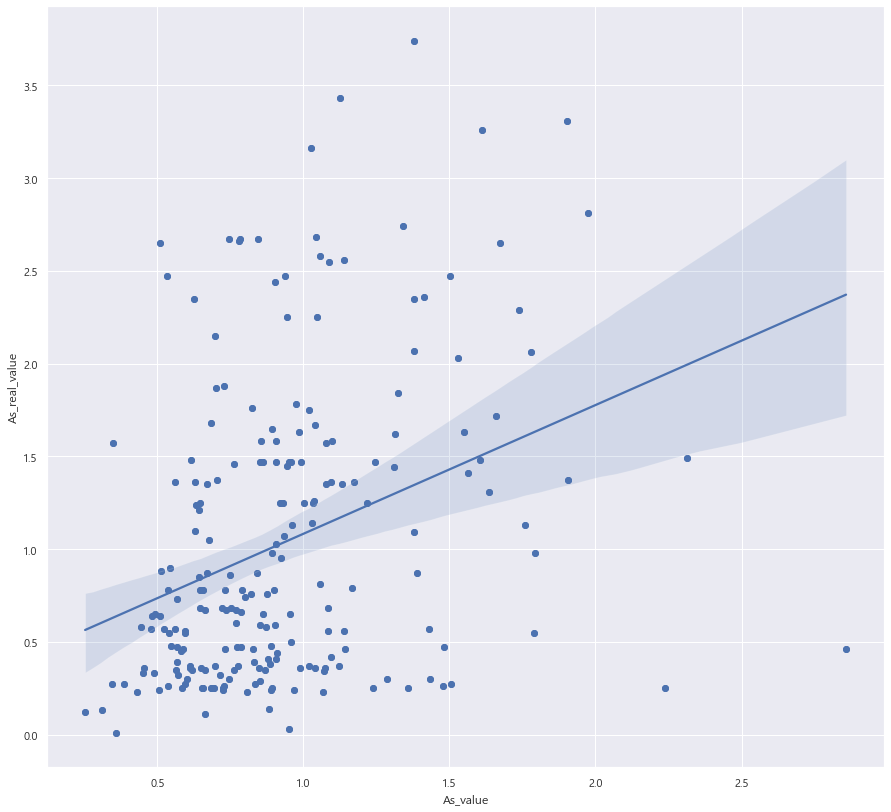

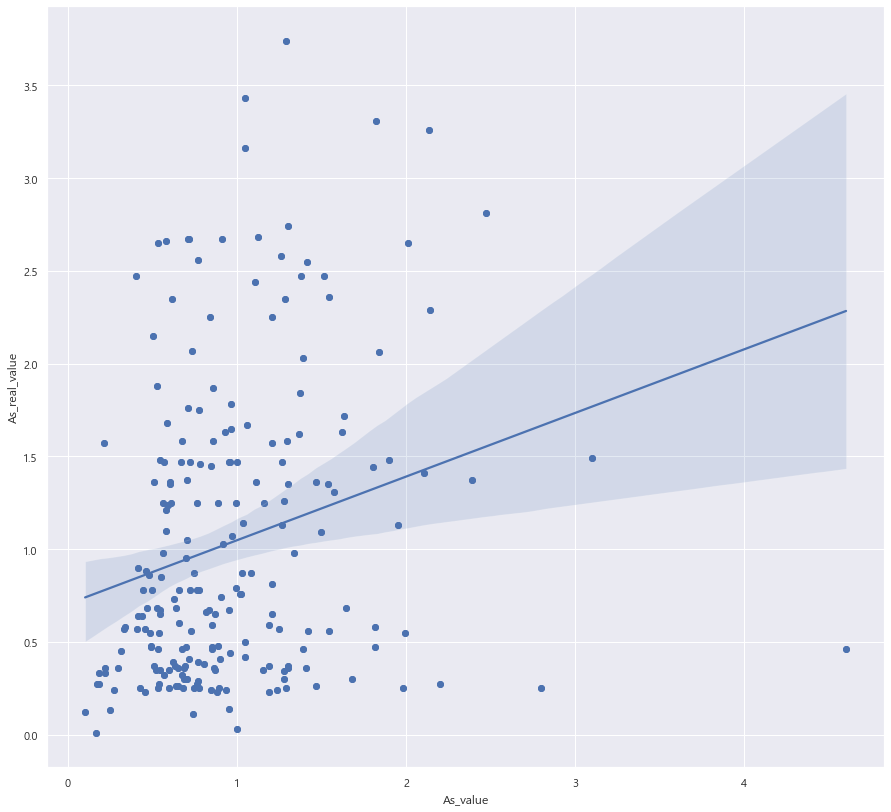

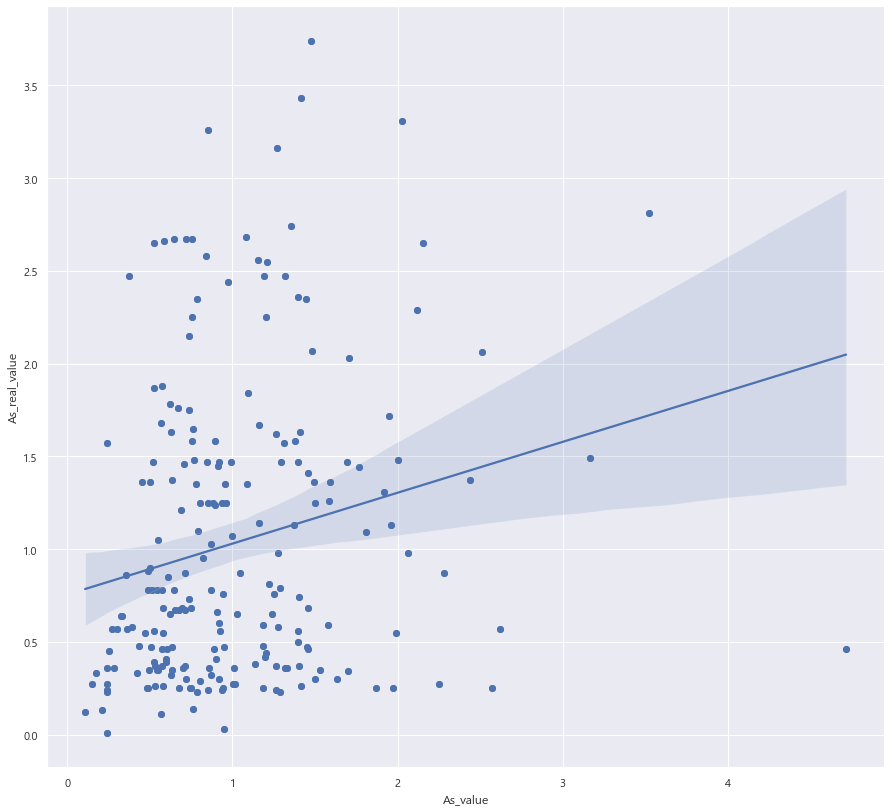

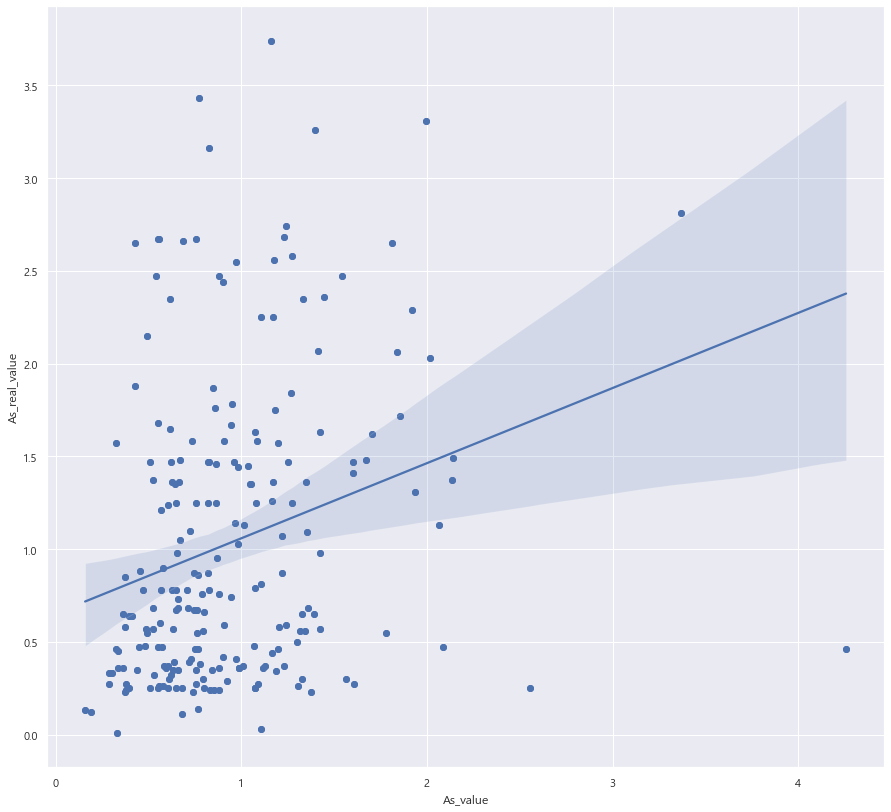

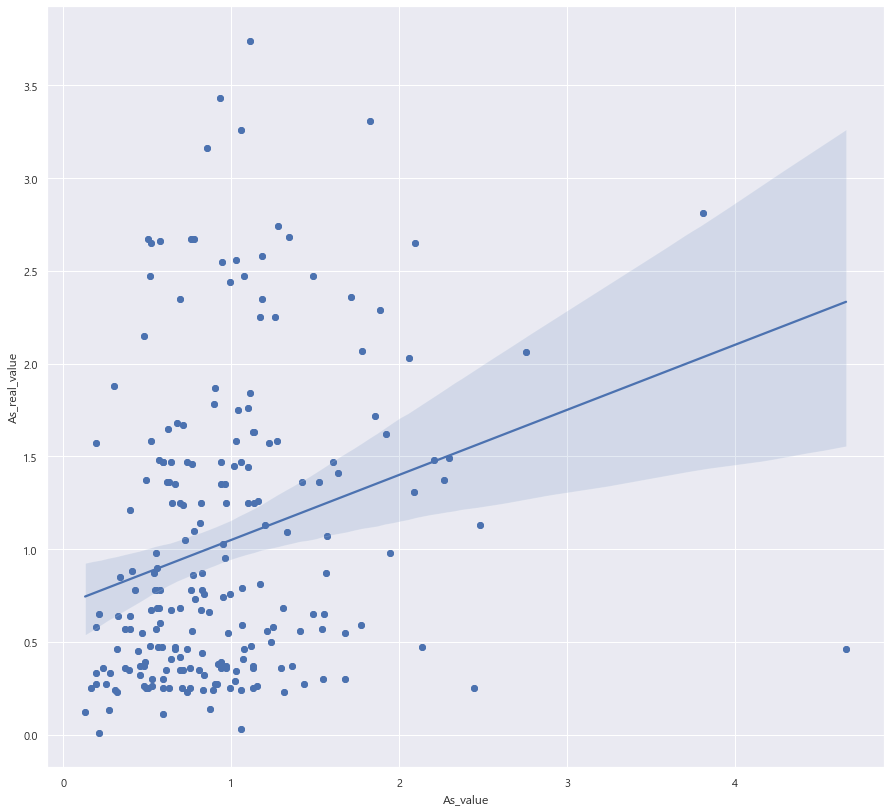

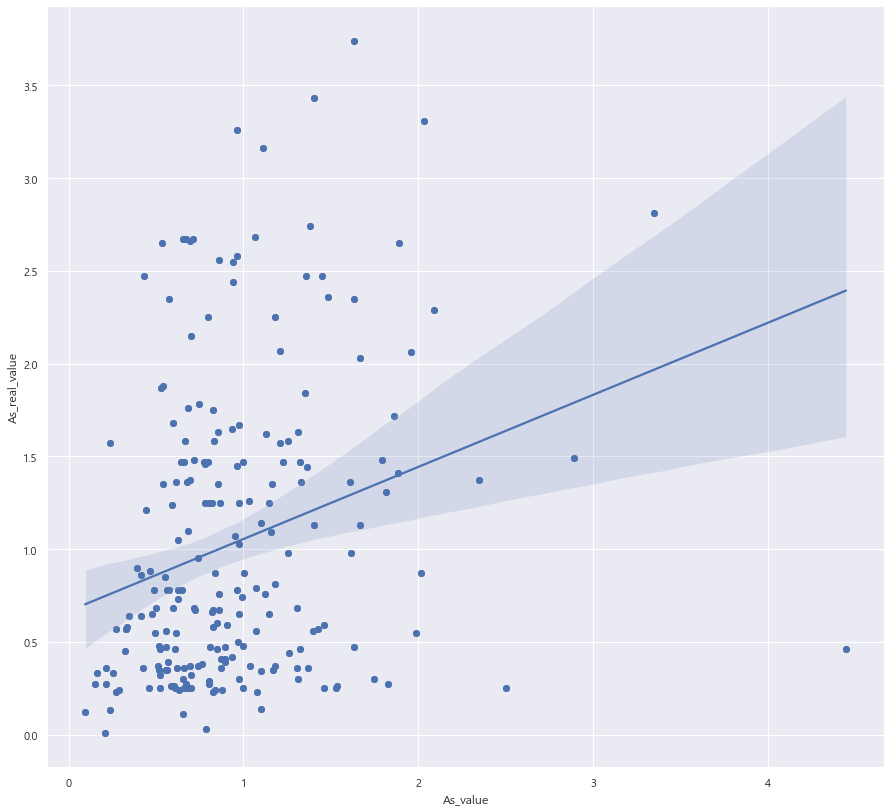

In [ ]:
plt.scatter(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
sns.regplot(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
plt.show()

plt.scatter(rf_As_test['As_value'], rf_As_test['As_real_value'])
sns.regplot(rf_As_test['As_value'], rf_As_test['As_real_value'])
plt.show()

plt.scatter(etc_As_test['As_value'], etc_As_test['As_real_value'])
sns.regplot(etc_As_test['As_value'], etc_As_test['As_real_value'])
plt.show()

plt.scatter(gb_As_test['As_value'], gb_As_test['As_real_value'])
sns.regplot(gb_As_test['As_value'], gb_As_test['As_real_value'])
plt.show()

plt.scatter(cb_As_test['As_value'], cb_As_test['As_real_value'])
sns.regplot(cb_As_test['As_value'], cb_As_test['As_real_value'])
plt.show()

plt.scatter(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
sns.regplot(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
plt.show()

plt.scatter(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
sns.regplot(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
plt.show()

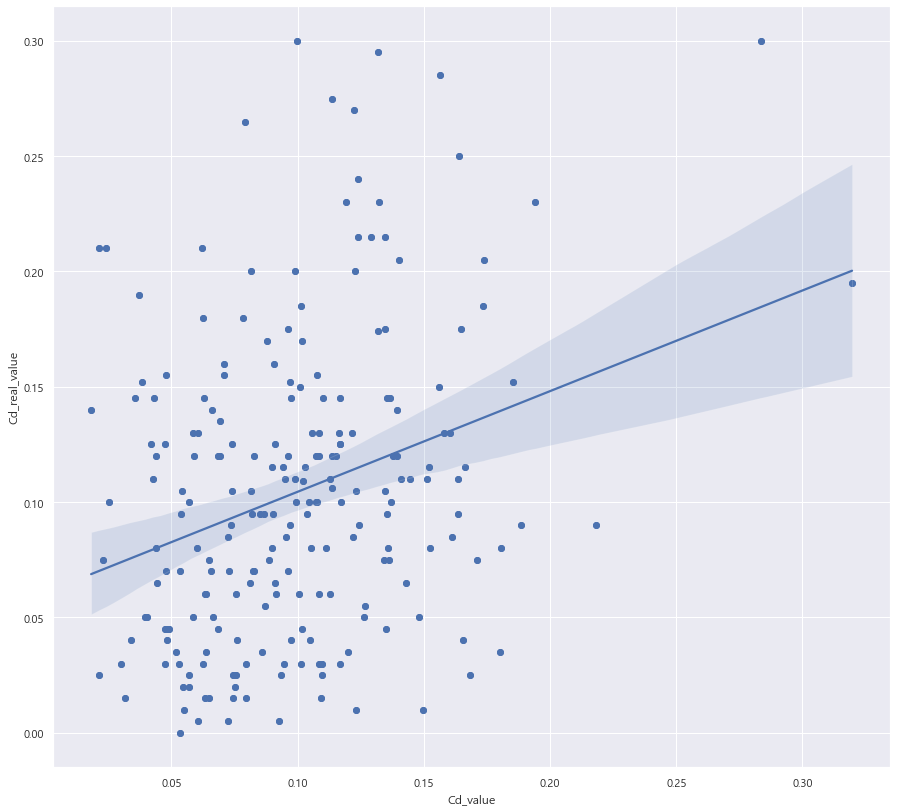

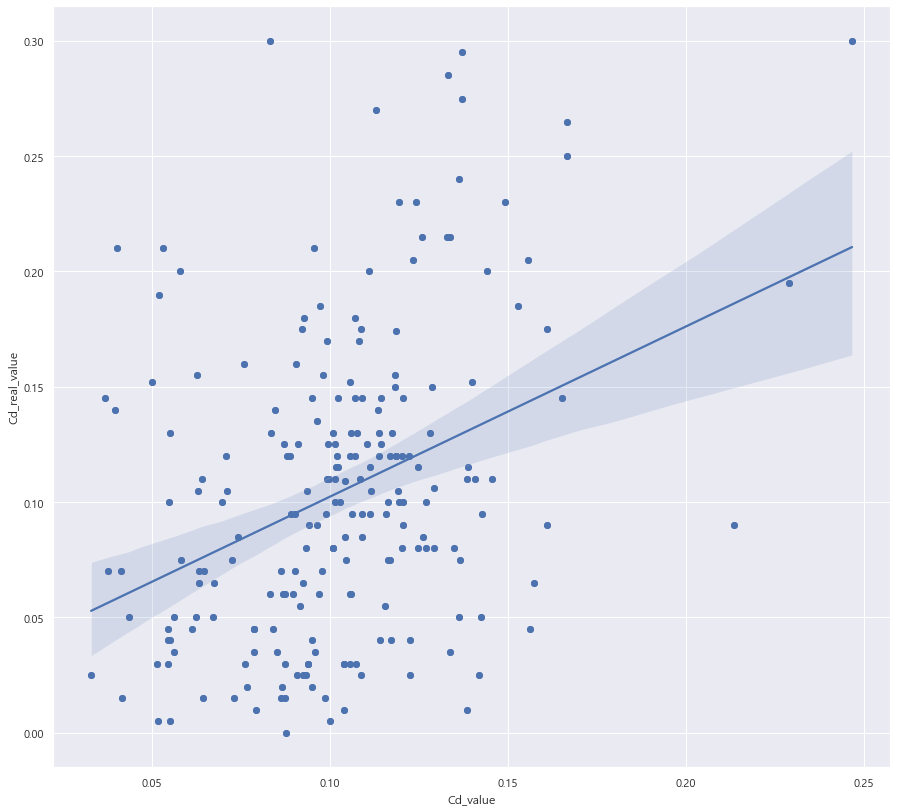

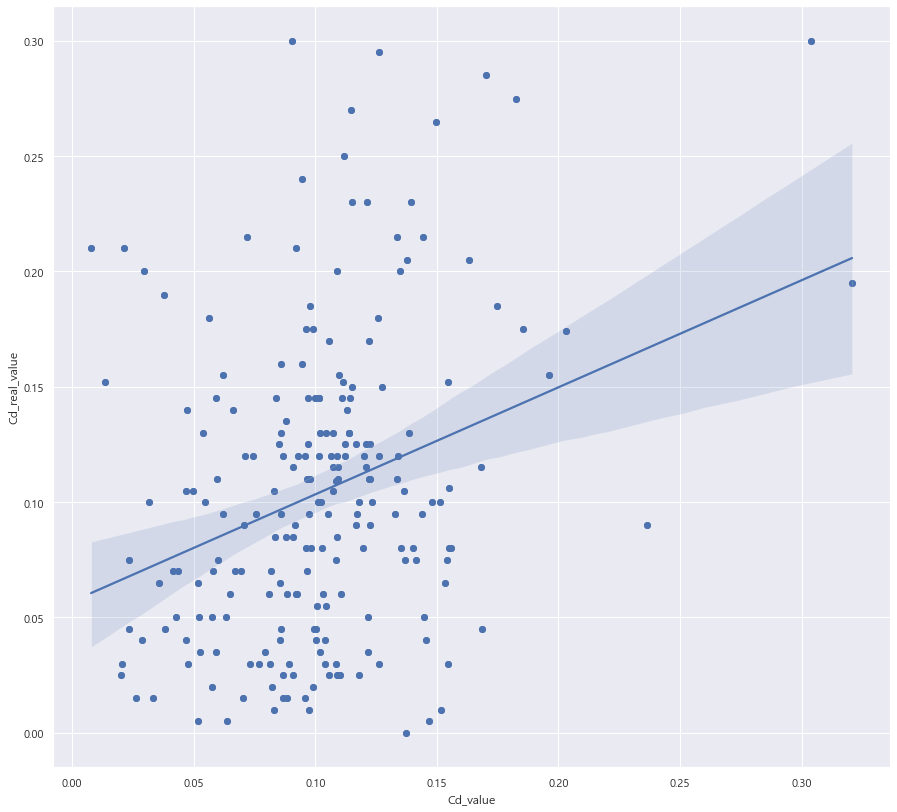

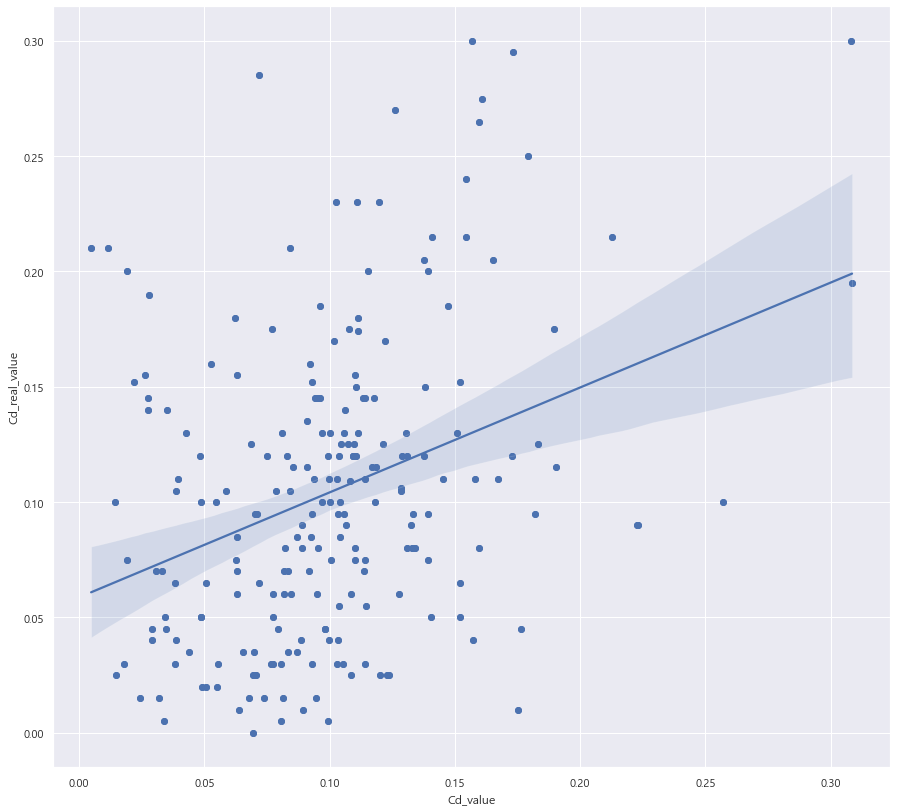

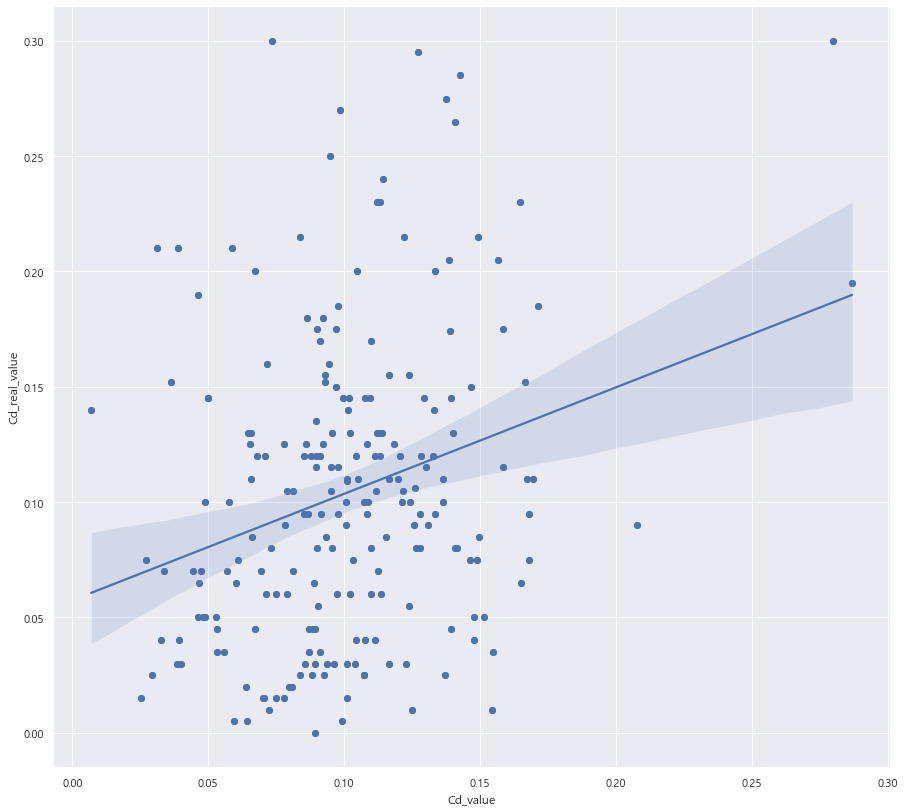

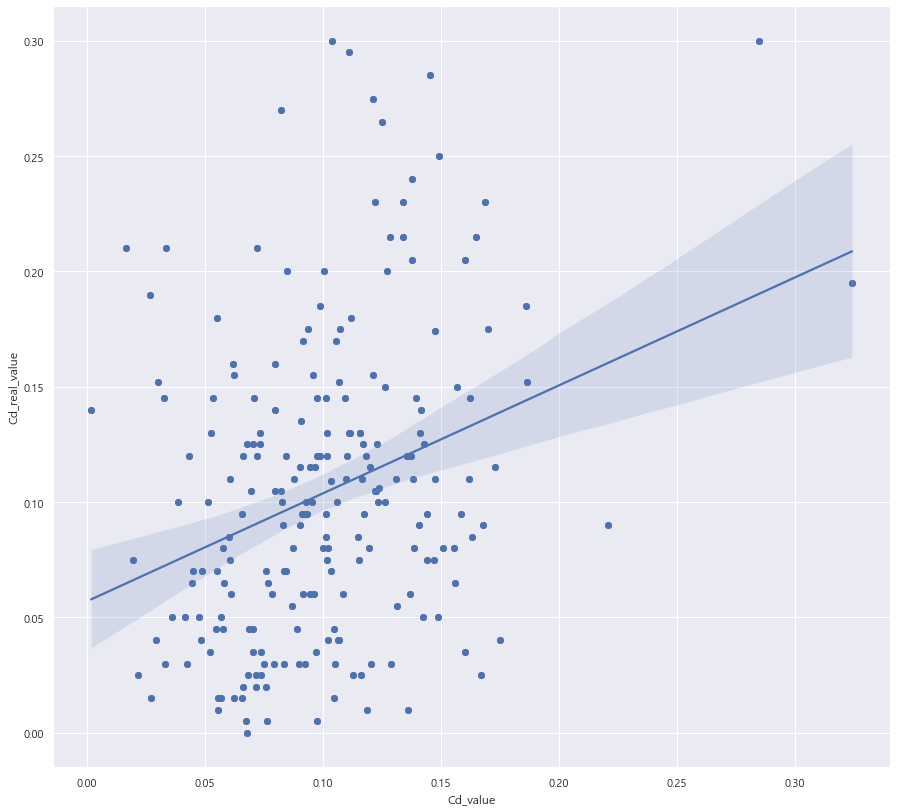

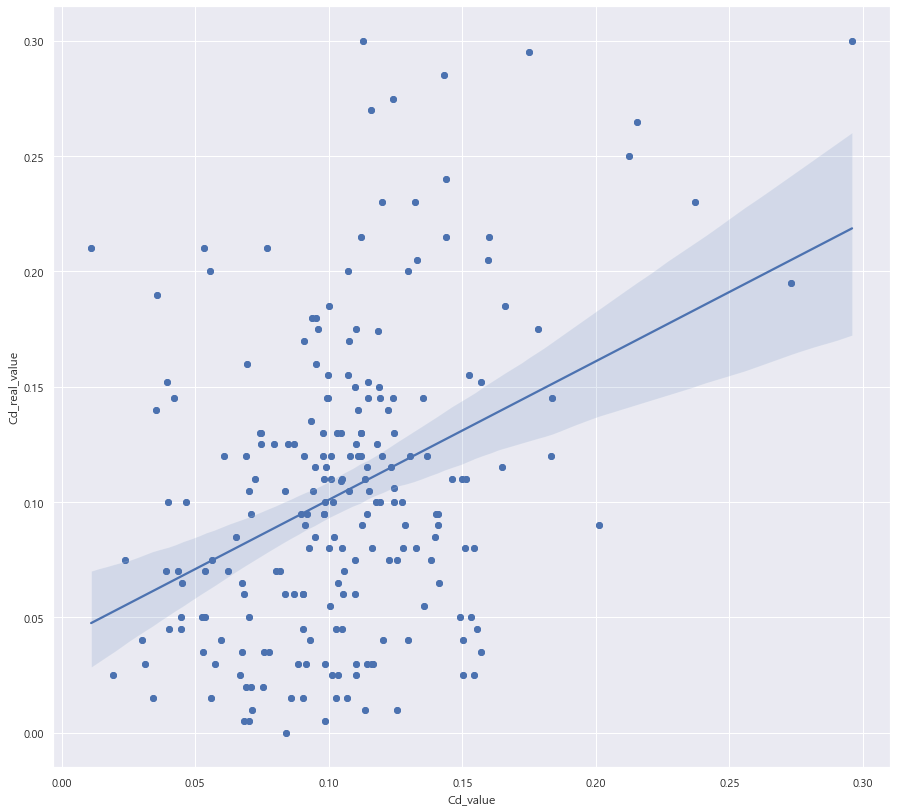

In [ ]:
plt.scatter(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
sns.regplot(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
sns.regplot(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
sns.regplot(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
sns.regplot(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
sns.regplot(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
sns.regplot(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
sns.regplot(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
plt.show()

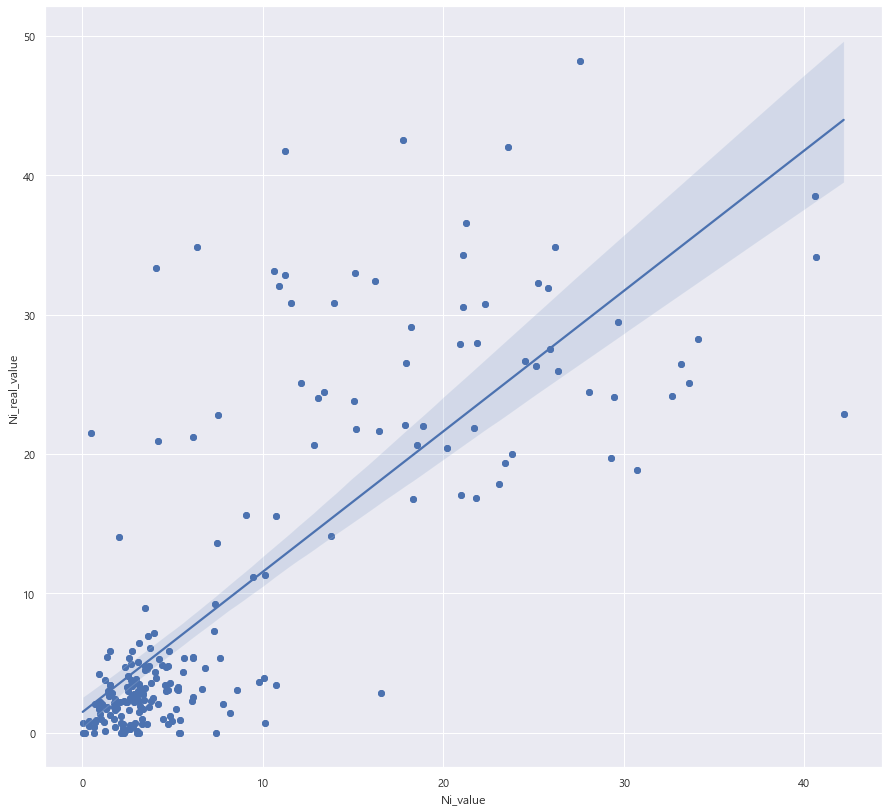

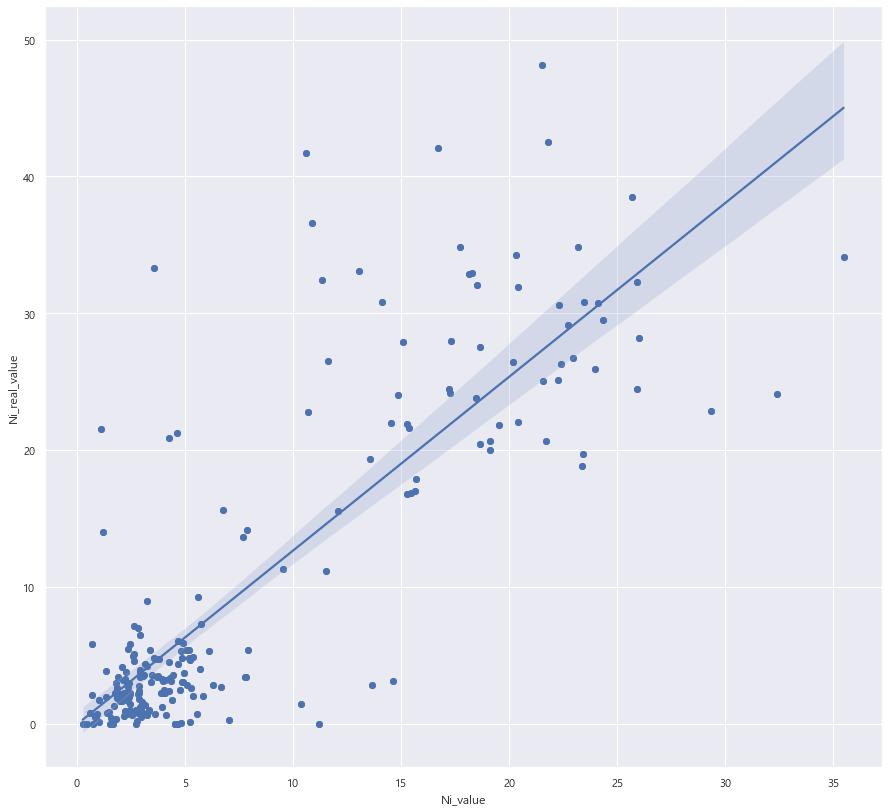

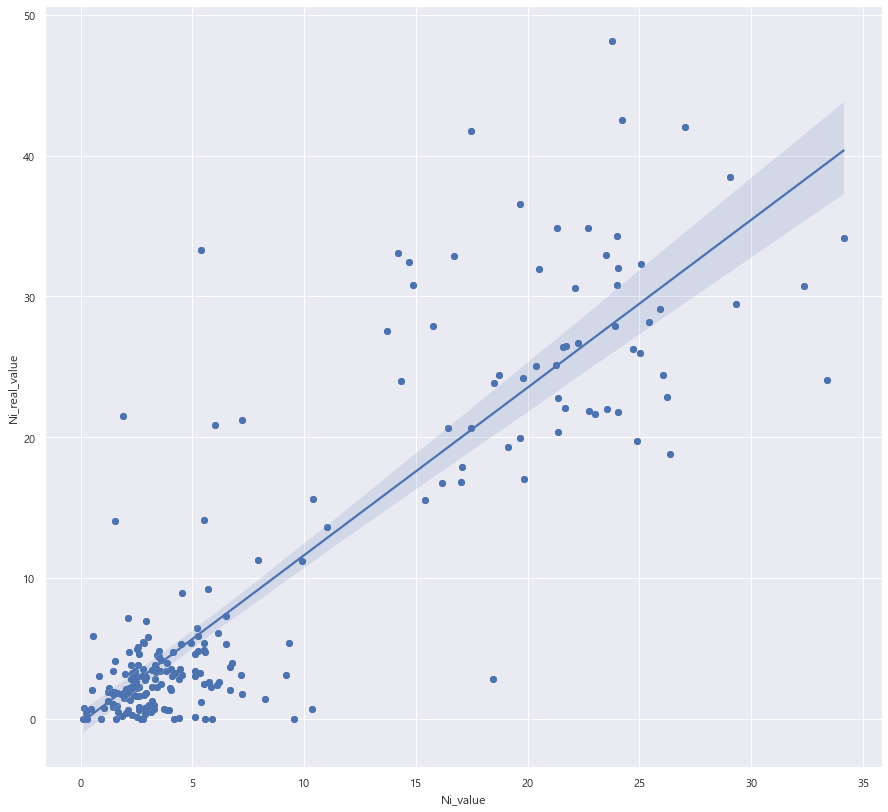

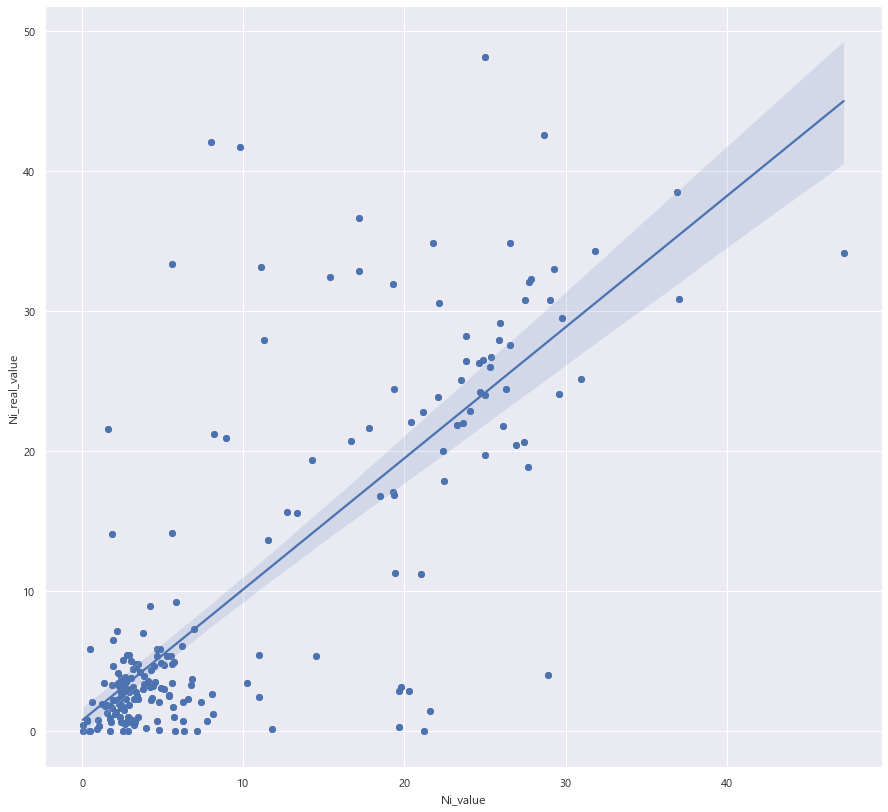

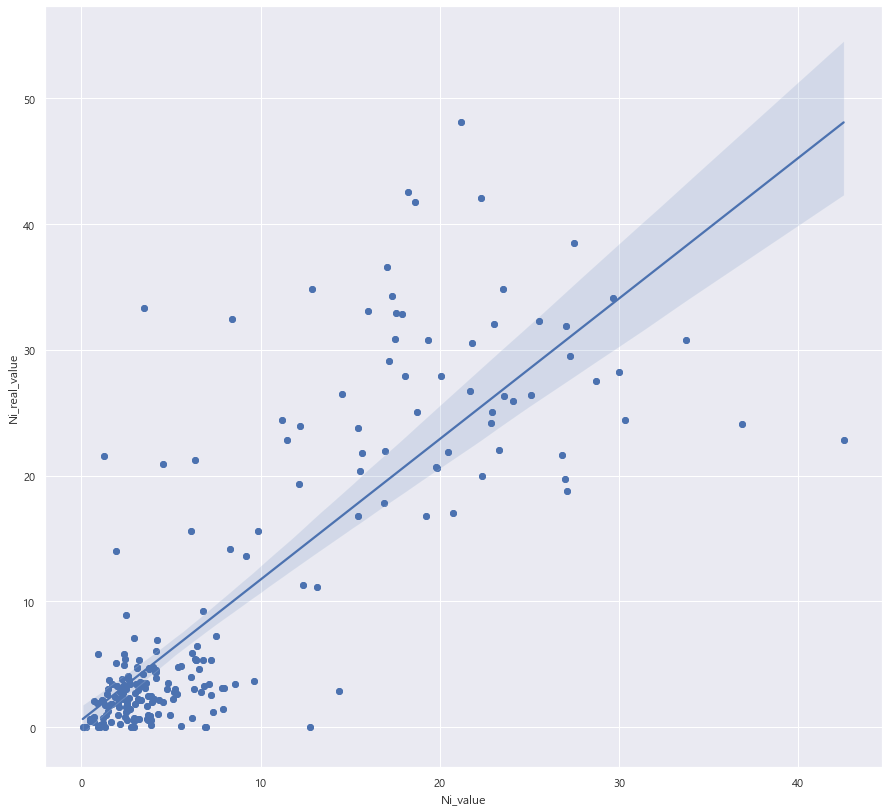

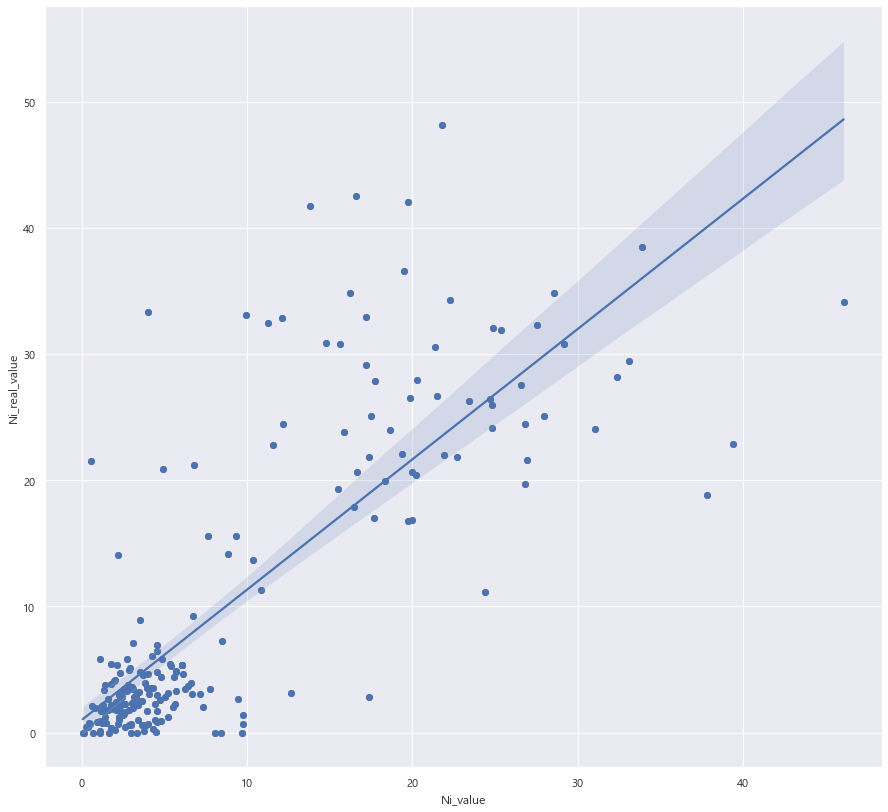

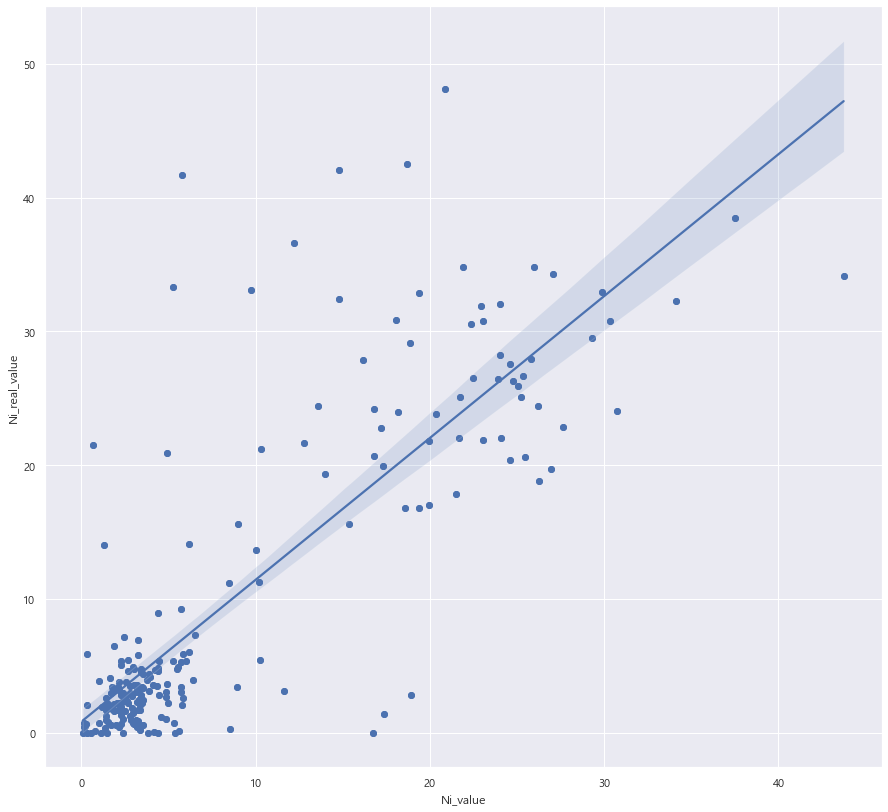

In [ ]:
plt.scatter(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
sns.regplot(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
sns.regplot(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
sns.regplot(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
sns.regplot(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
sns.regplot(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
sns.regplot(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
sns.regplot(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
plt.show()